# Bank Marketing Campaign Data Science Project
---

First, we will import the data and necessary packages:

In [73]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook', font_scale= 0.7)

In [2]:
from ucimlrepo import fetch_ucirepo
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
df = X.join(y)

## Exploratory Data Analysis

We can see some basic information regarding our variables now. Let's call the head and info of our dataset to see what it looks like. 

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


We might end up changing 'yes/no' binary variables for boolean values or 0/1 for modeling purposes.

We will mainly be visualizing our explanatory variables in relation to our target variable 'subscription' (our 'y', or more specifically,whether or not the person subscribed a term deposit or not). 

Our data seems to be highly imbalanced, with only about 12% of people subscribing to the term deposit.

Text(0.5, 1.0, 'Amount of people by whether or not they subscribed a term deposit')

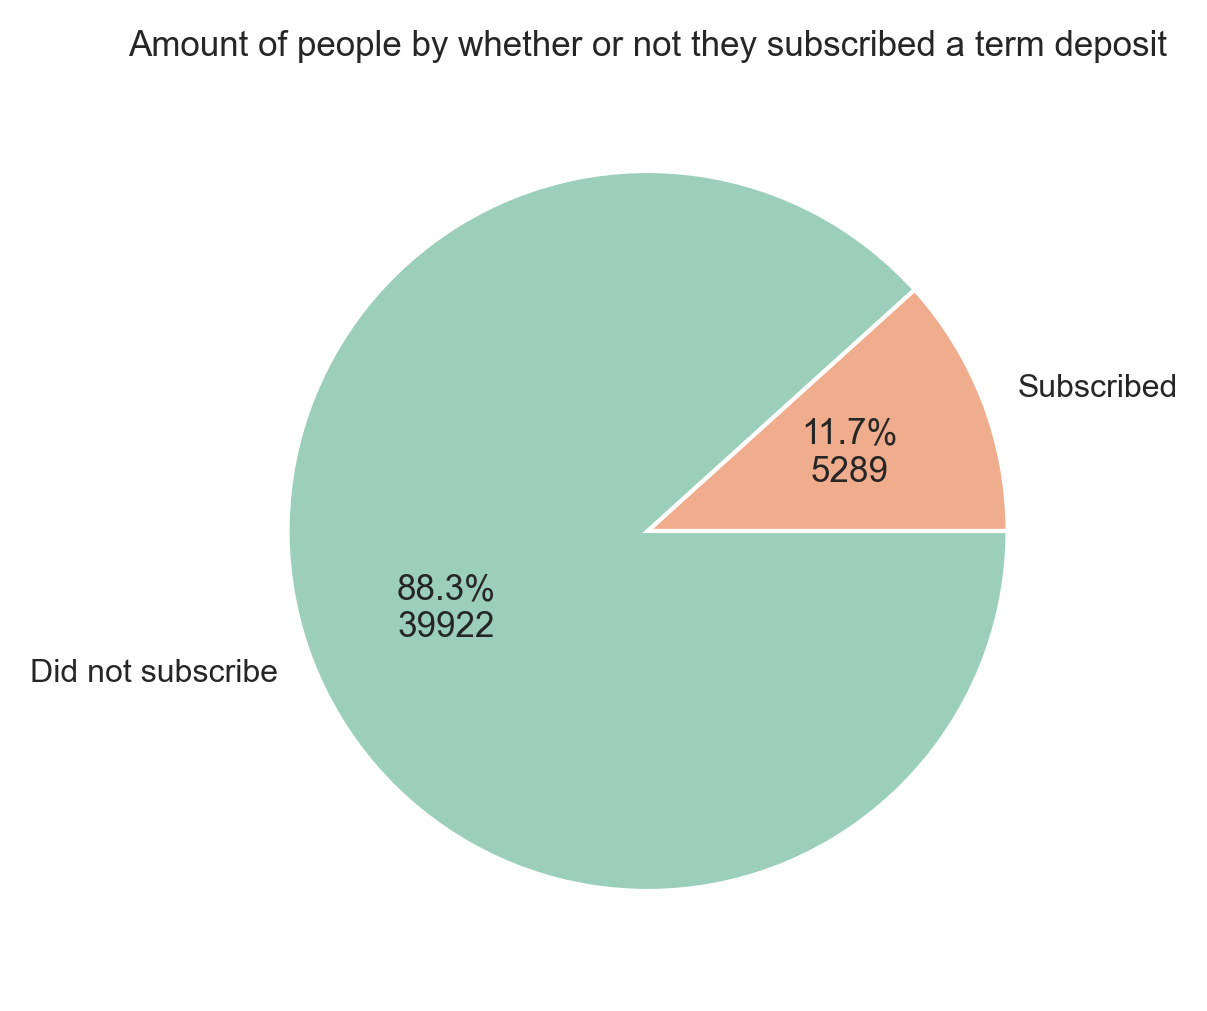

In [24]:
y_yes = df['y'][df['y'] == 1].count()  
y_no = df['y'][df['y'] == 0].count()

def my_fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, df['y'].count()*x/100)

sns.set_style('white')
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])
plt.pie([y_yes, y_no], labels = ['Subscribed', 'Did not subscribe'], colors = ['#F0AD8E', "#9BCFBC"], autopct = my_fmt)
ax.set_title("Amount of people by whether or not they subscribed a term deposit")

With the bulk of the people in our data being between 25 and 59 years of age, it is worth noting the proportion of people that subscribed is considerably higher for older people (about 50% on the last two bins), although it is not very noticeable because the total amount of those people in our data is very low in comparison to younger adults.

Text(0.5, 1.0, 'Histogram of age by subscription')

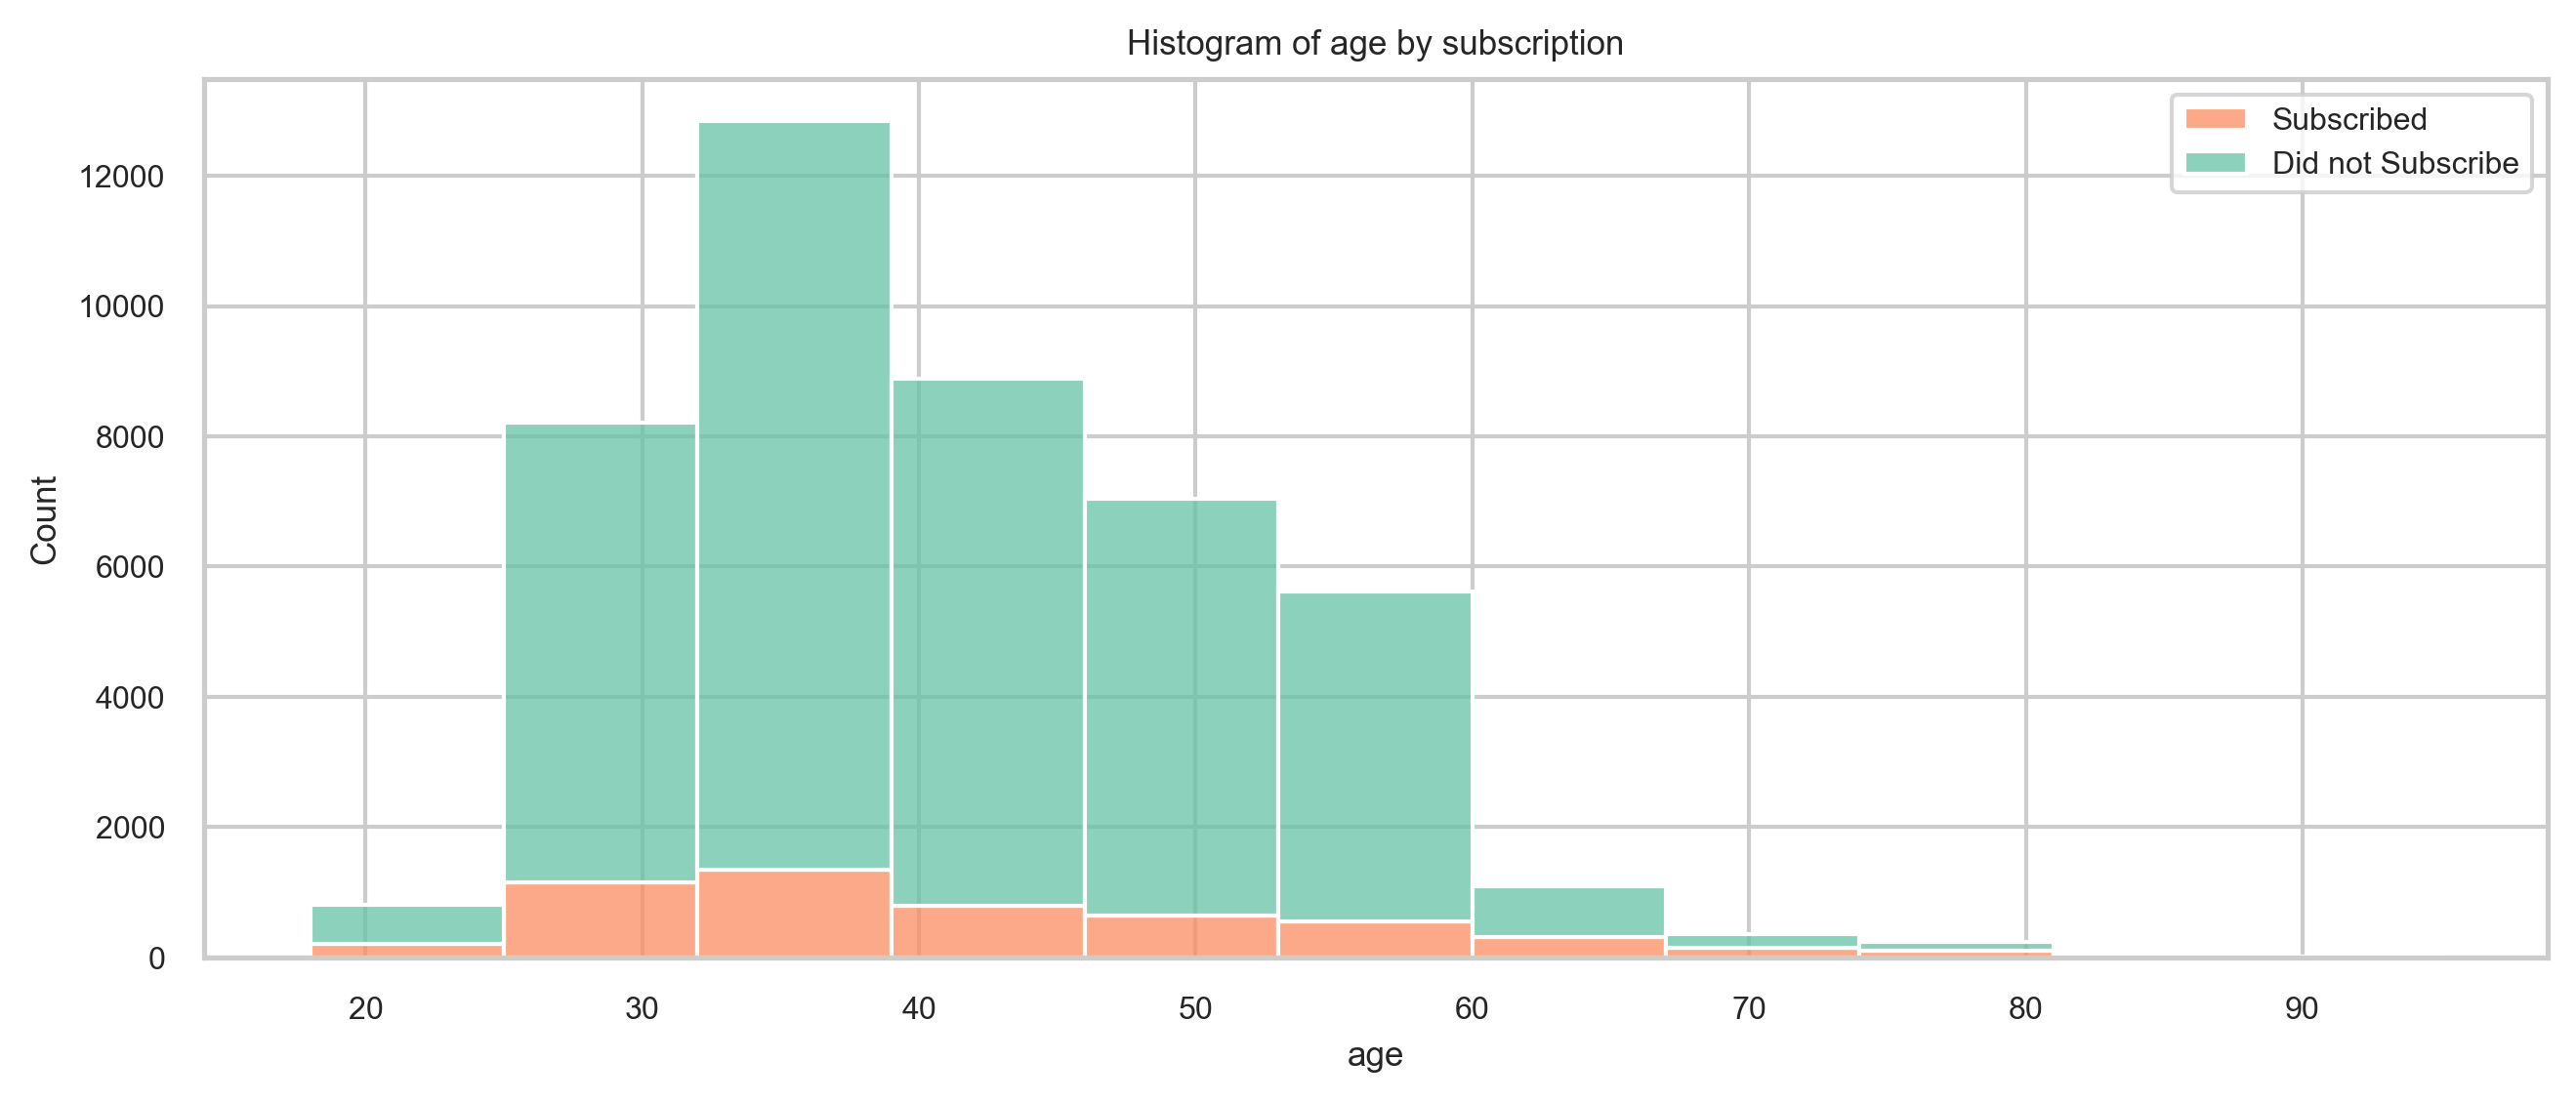

In [25]:
sns.set_style('whitegrid')
sns.diverging_palette(220, 20, as_cmap=True)
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])
sns.histplot(df, x = 'age', hue = 'y', palette = 'Set2', bins = 11, multiple = 'stack')
ax.legend(labels = ['Subscribed', 'Did not Subscribe'])
ax.set_title("Histogram of age by subscription")

People called at the beginning of the month were more inclined to subscribe a term deposit - especially the first day, where more than 25% of all people did so. Although this proportion has peaks, notably on days 10, 22 and 30, it descends consistently as the month goes by.

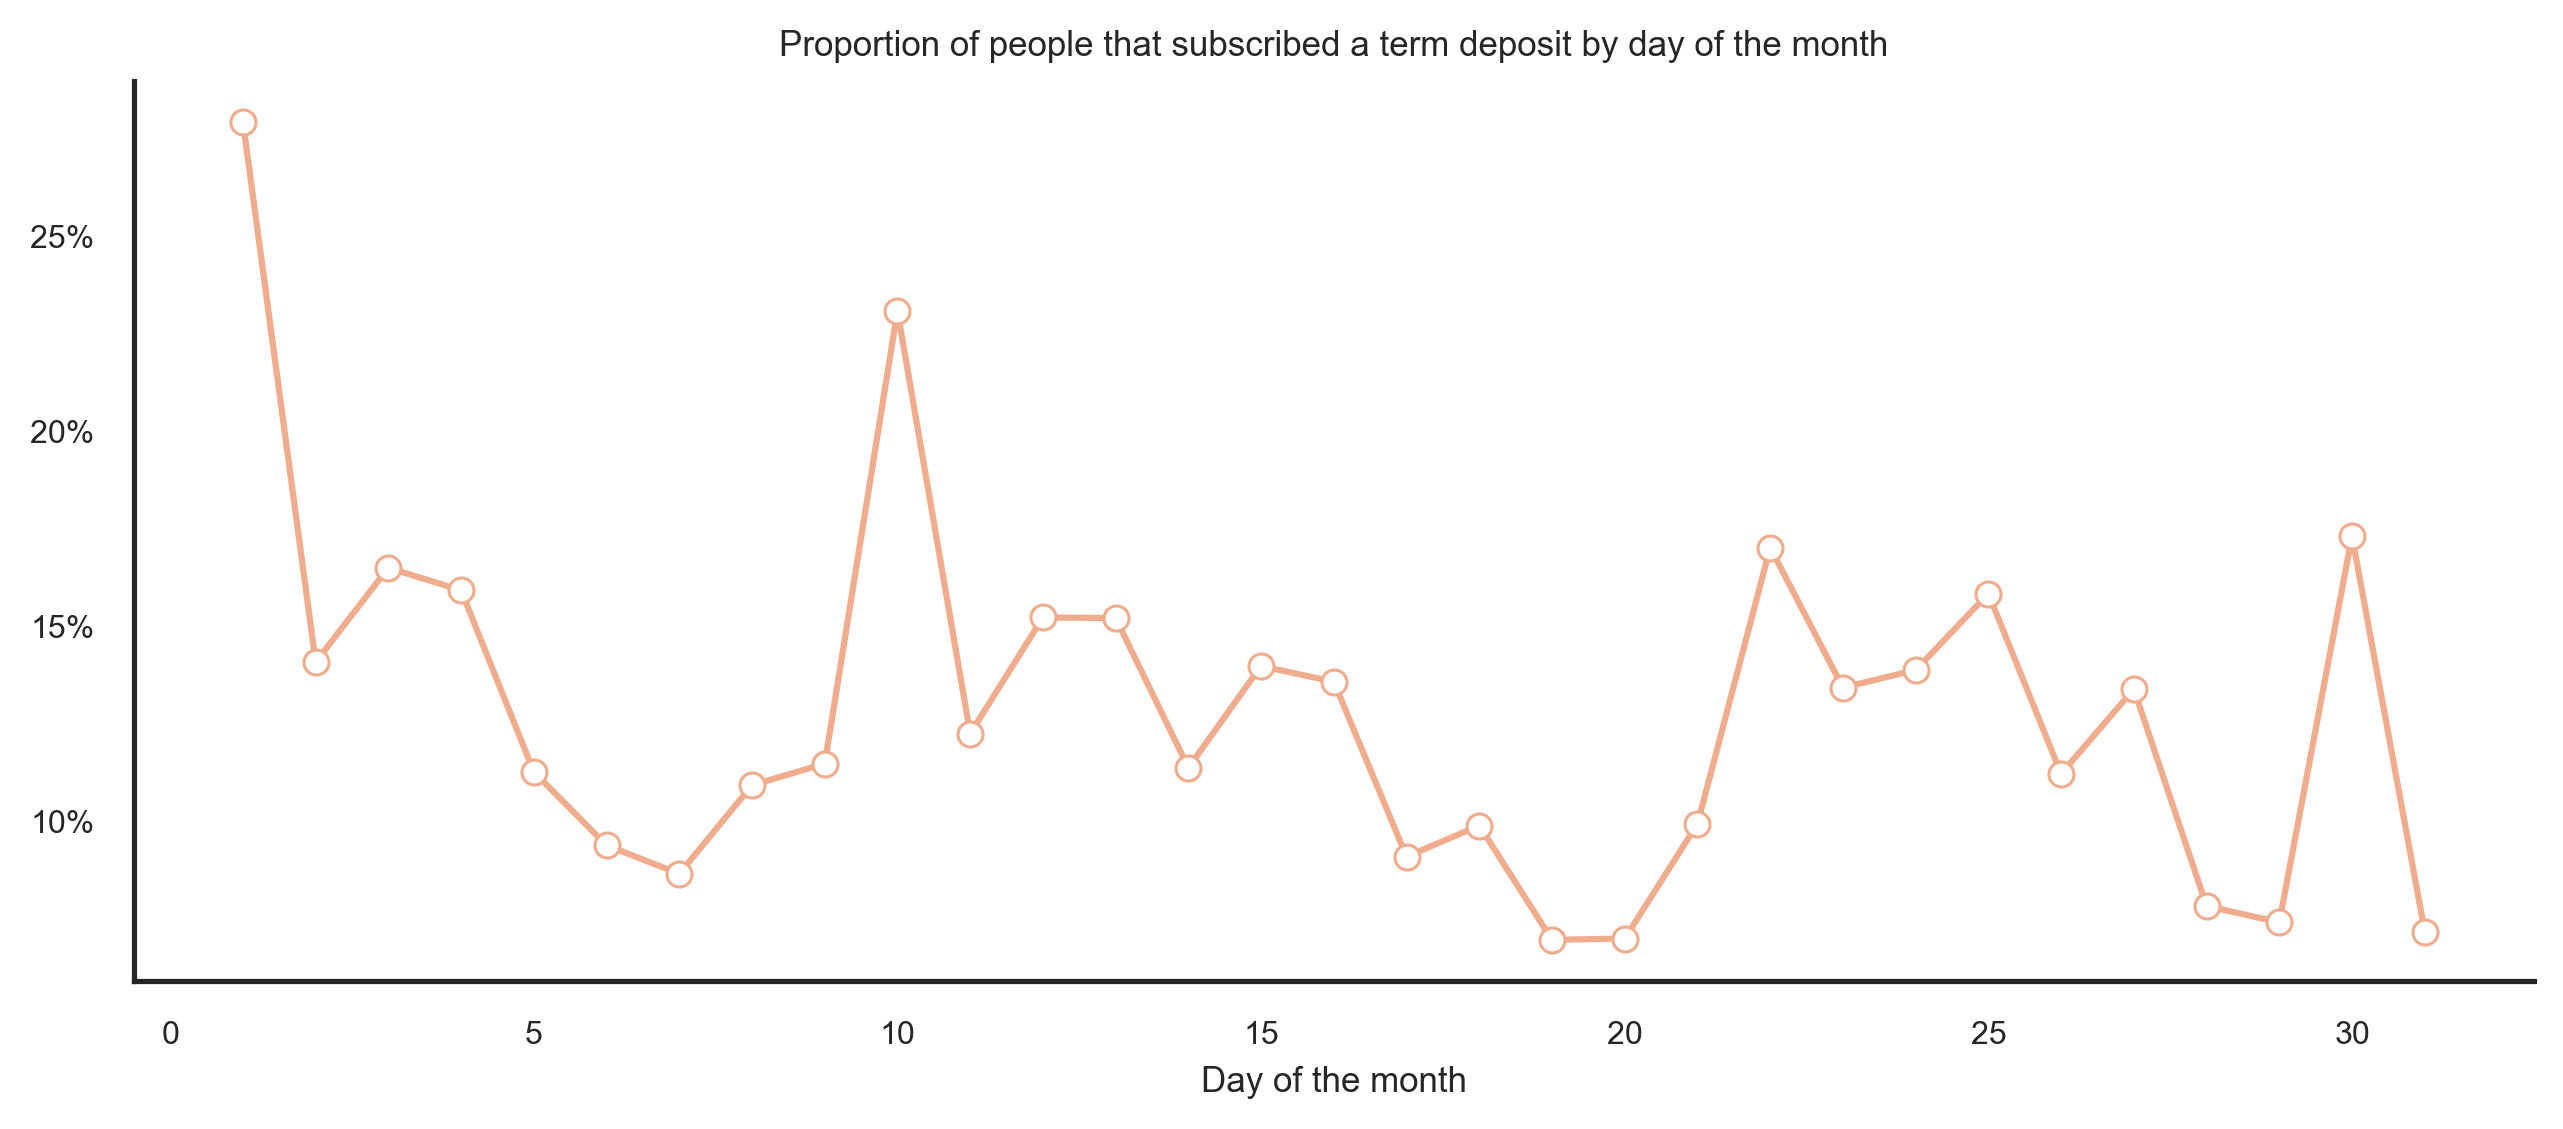

In [26]:
a = df.groupby('day_of_week').count()['y']
b = df[df['y'] == 1].groupby('day_of_week').count()['y']
c = b/a

sns.set_style('white')
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])
sns.lineplot(c, color = '#F0AD8E', marker = 'o', markerfacecolor = 'white', markeredgecolor = '#F0AD8E')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_ylabel('')
ax.set_xlabel('Day of the month')
ax.set_title("Proportion of people that subscribed a term deposit by day of the month")
sns.despine()


Now, let's check some overlapping stacked bar graphs to measure how many people actually subscribed a term deposit and which categorical groups are the most inclined to subscribe, based on the proportion that did so out of the people called.

Although May holds the most people called by far, the proportion of those that subscribed is relatively low. Other months like March, April, September, and October had a higher success rate.

Text(0.5, 1.0, 'Number of people by month and subscription')

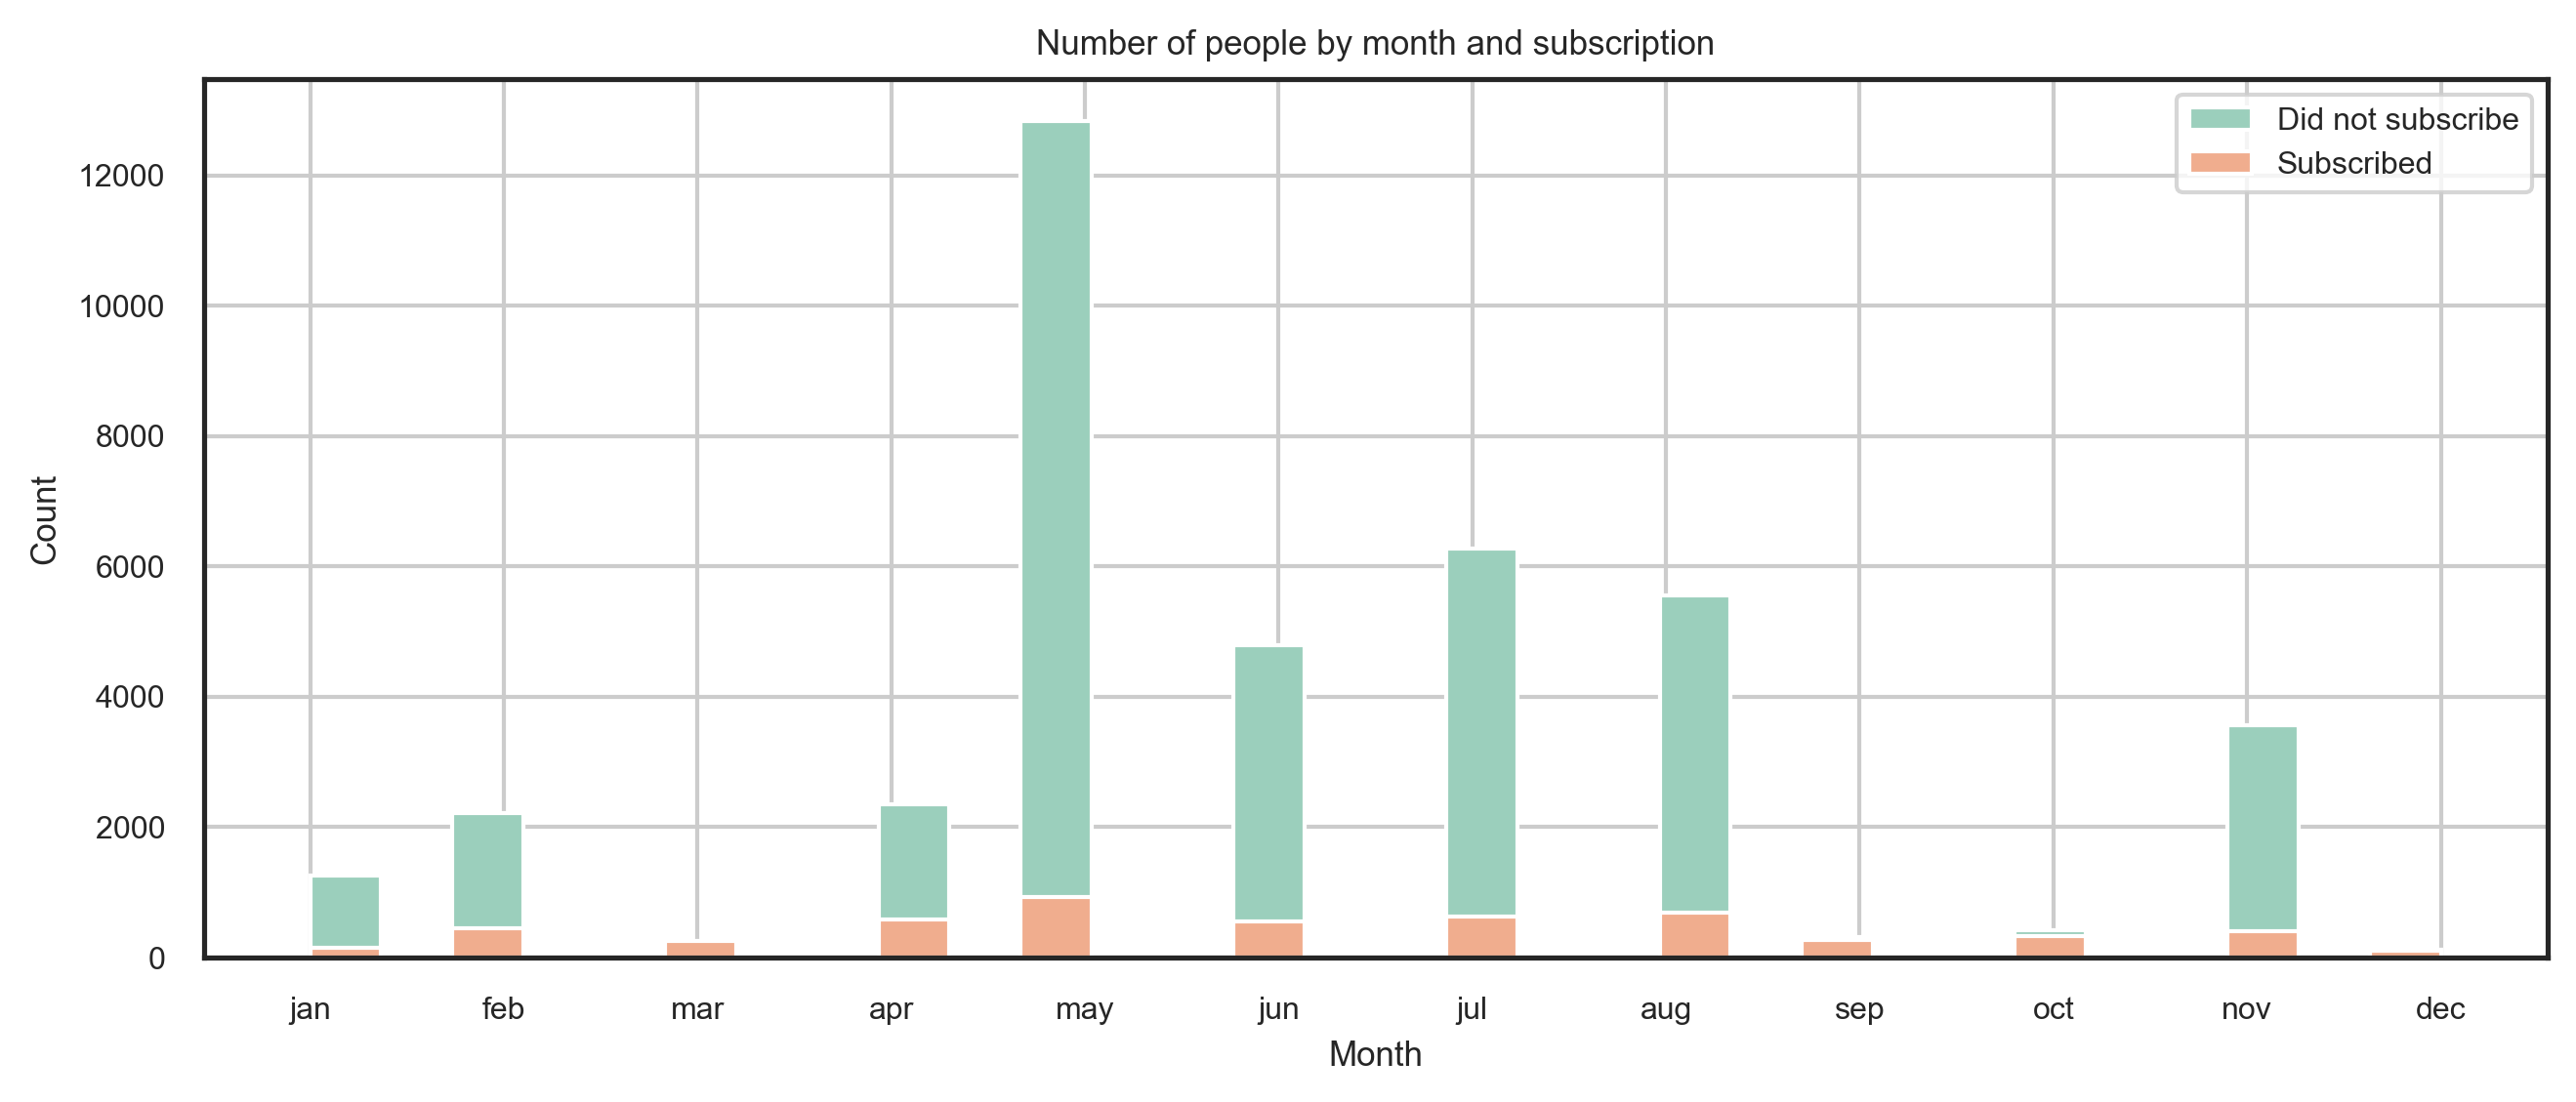

In [27]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])

months = ["jan", "feb", "mar", "apr", "may", "jun", 
          "jul", "aug", "sep", "oct", "nov", "dec"]
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)
df.sort_values(by = 'month', inplace = True)

df[df['y'] == 0]['month'].hist(color ='#9BCFBC', bins=30, label = 'Did not subscribe')
df[df['y'] == 1]['month'].hist(color ='#F0AD8E', bins=30, label='Subscribed')

plt.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Month')
ax.set_title("Number of people by month and subscription")

Similarly, while most people called had blue-collar jobs, much more people from management and technician jobs actually subscribed a term deposit. In terms of proportions, students and retired people were more inclined to subscribe.

Text(0.5, 1.0, 'Number of people by job and subscription')

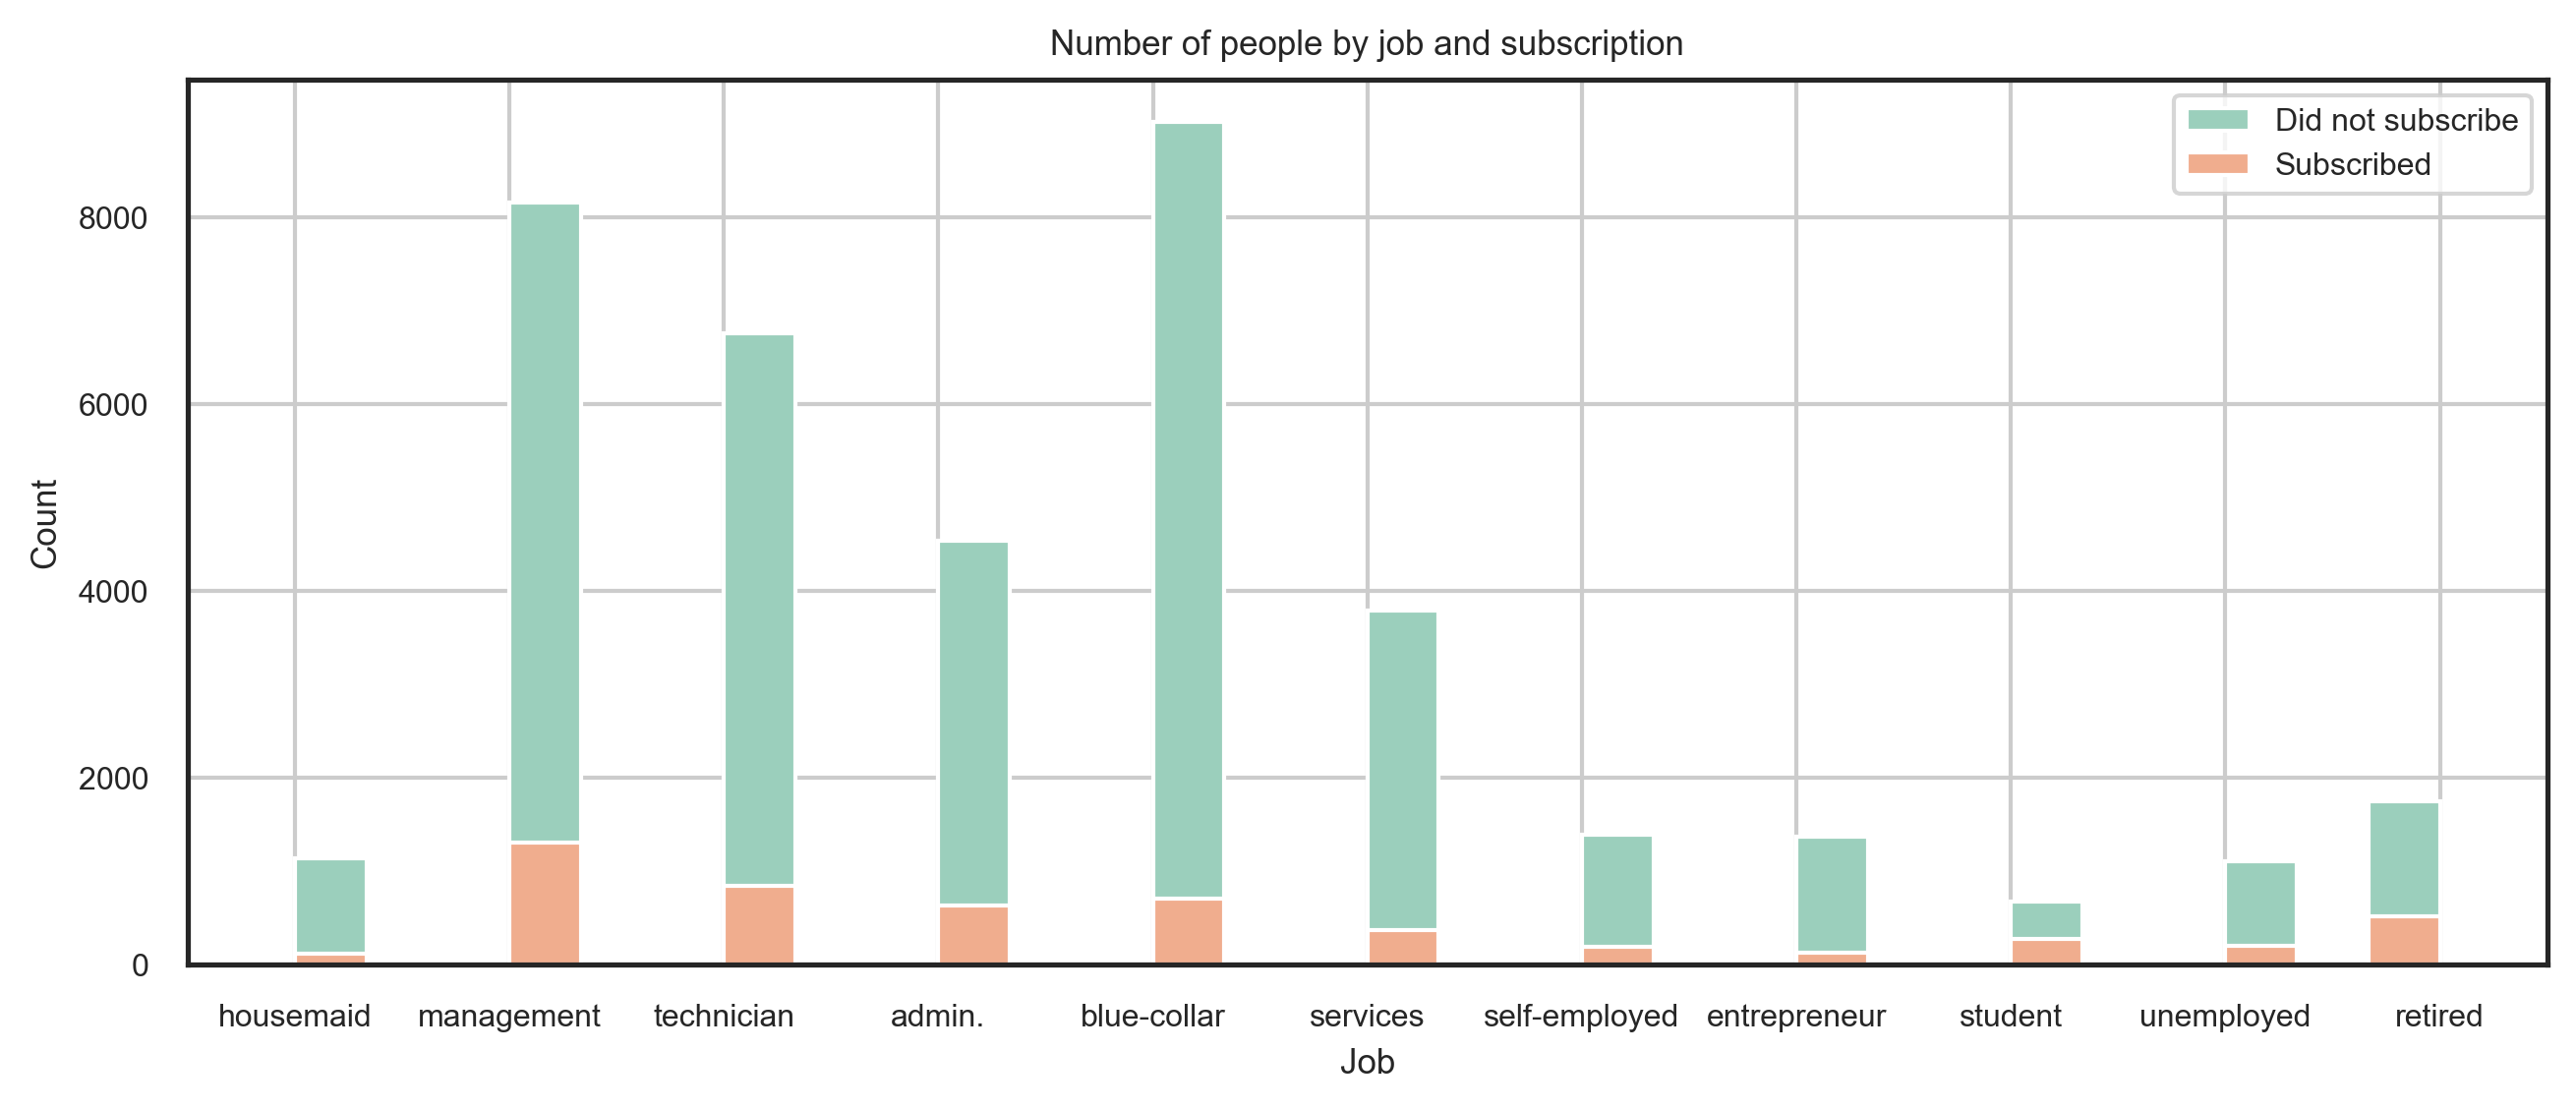

In [28]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])

df[df['y'] == 0]['job'].hist(color ='#9BCFBC', bins=30, label = 'Did not subscribe')
df[df['y'] == 1]['job'].hist(color ='#F0AD8E', bins=30, label='Subscribed')

plt.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Job')
ax.set_title("Number of people by job and subscription")

People with secondary education seemed to be the most called, but people with tertiary education subscribed the most.

Text(0.5, 1.0, 'Number of people by education achieved and subscription')

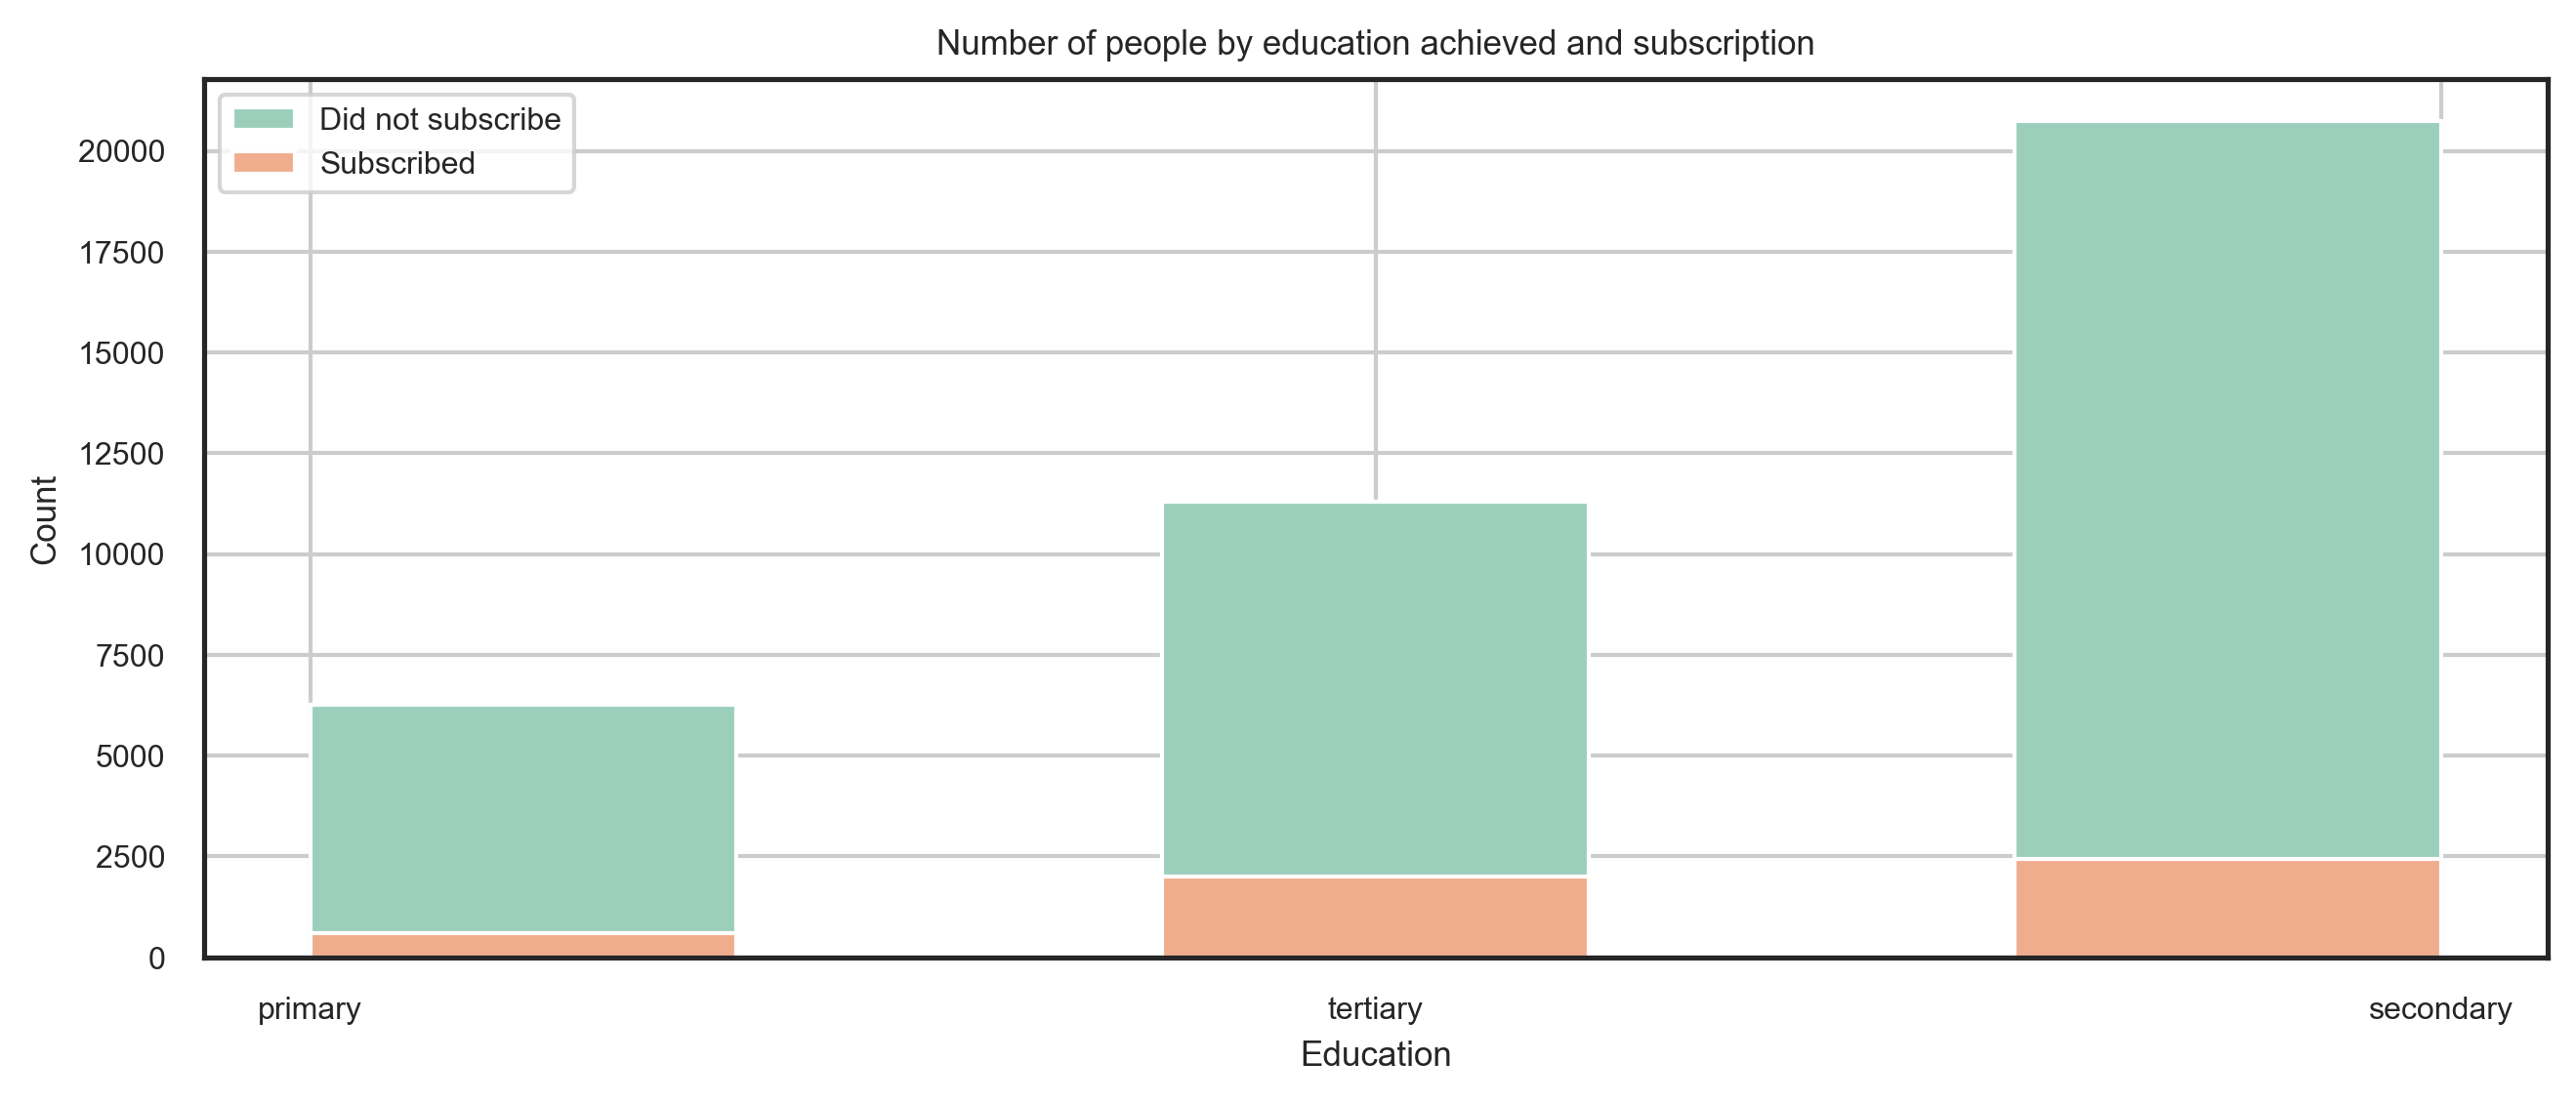

In [29]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])

df[df['y'] == 0]['education'].hist(color ='#9BCFBC', bins = 5, label = 'Did not subscribe')
df[df['y'] == 1]['education'].hist(color ='#F0AD8E', bins = 5, label = 'Subscribed')

plt.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Education')
ax.set_title("Number of people by education achieved and subscription")

Finally, it is worth noting that, predictably, people with personal loans were not too interested in subscribing a term deposit.

Text(0.5, 1.0, 'Number of people by whether they have a personal loan or not and subscription')

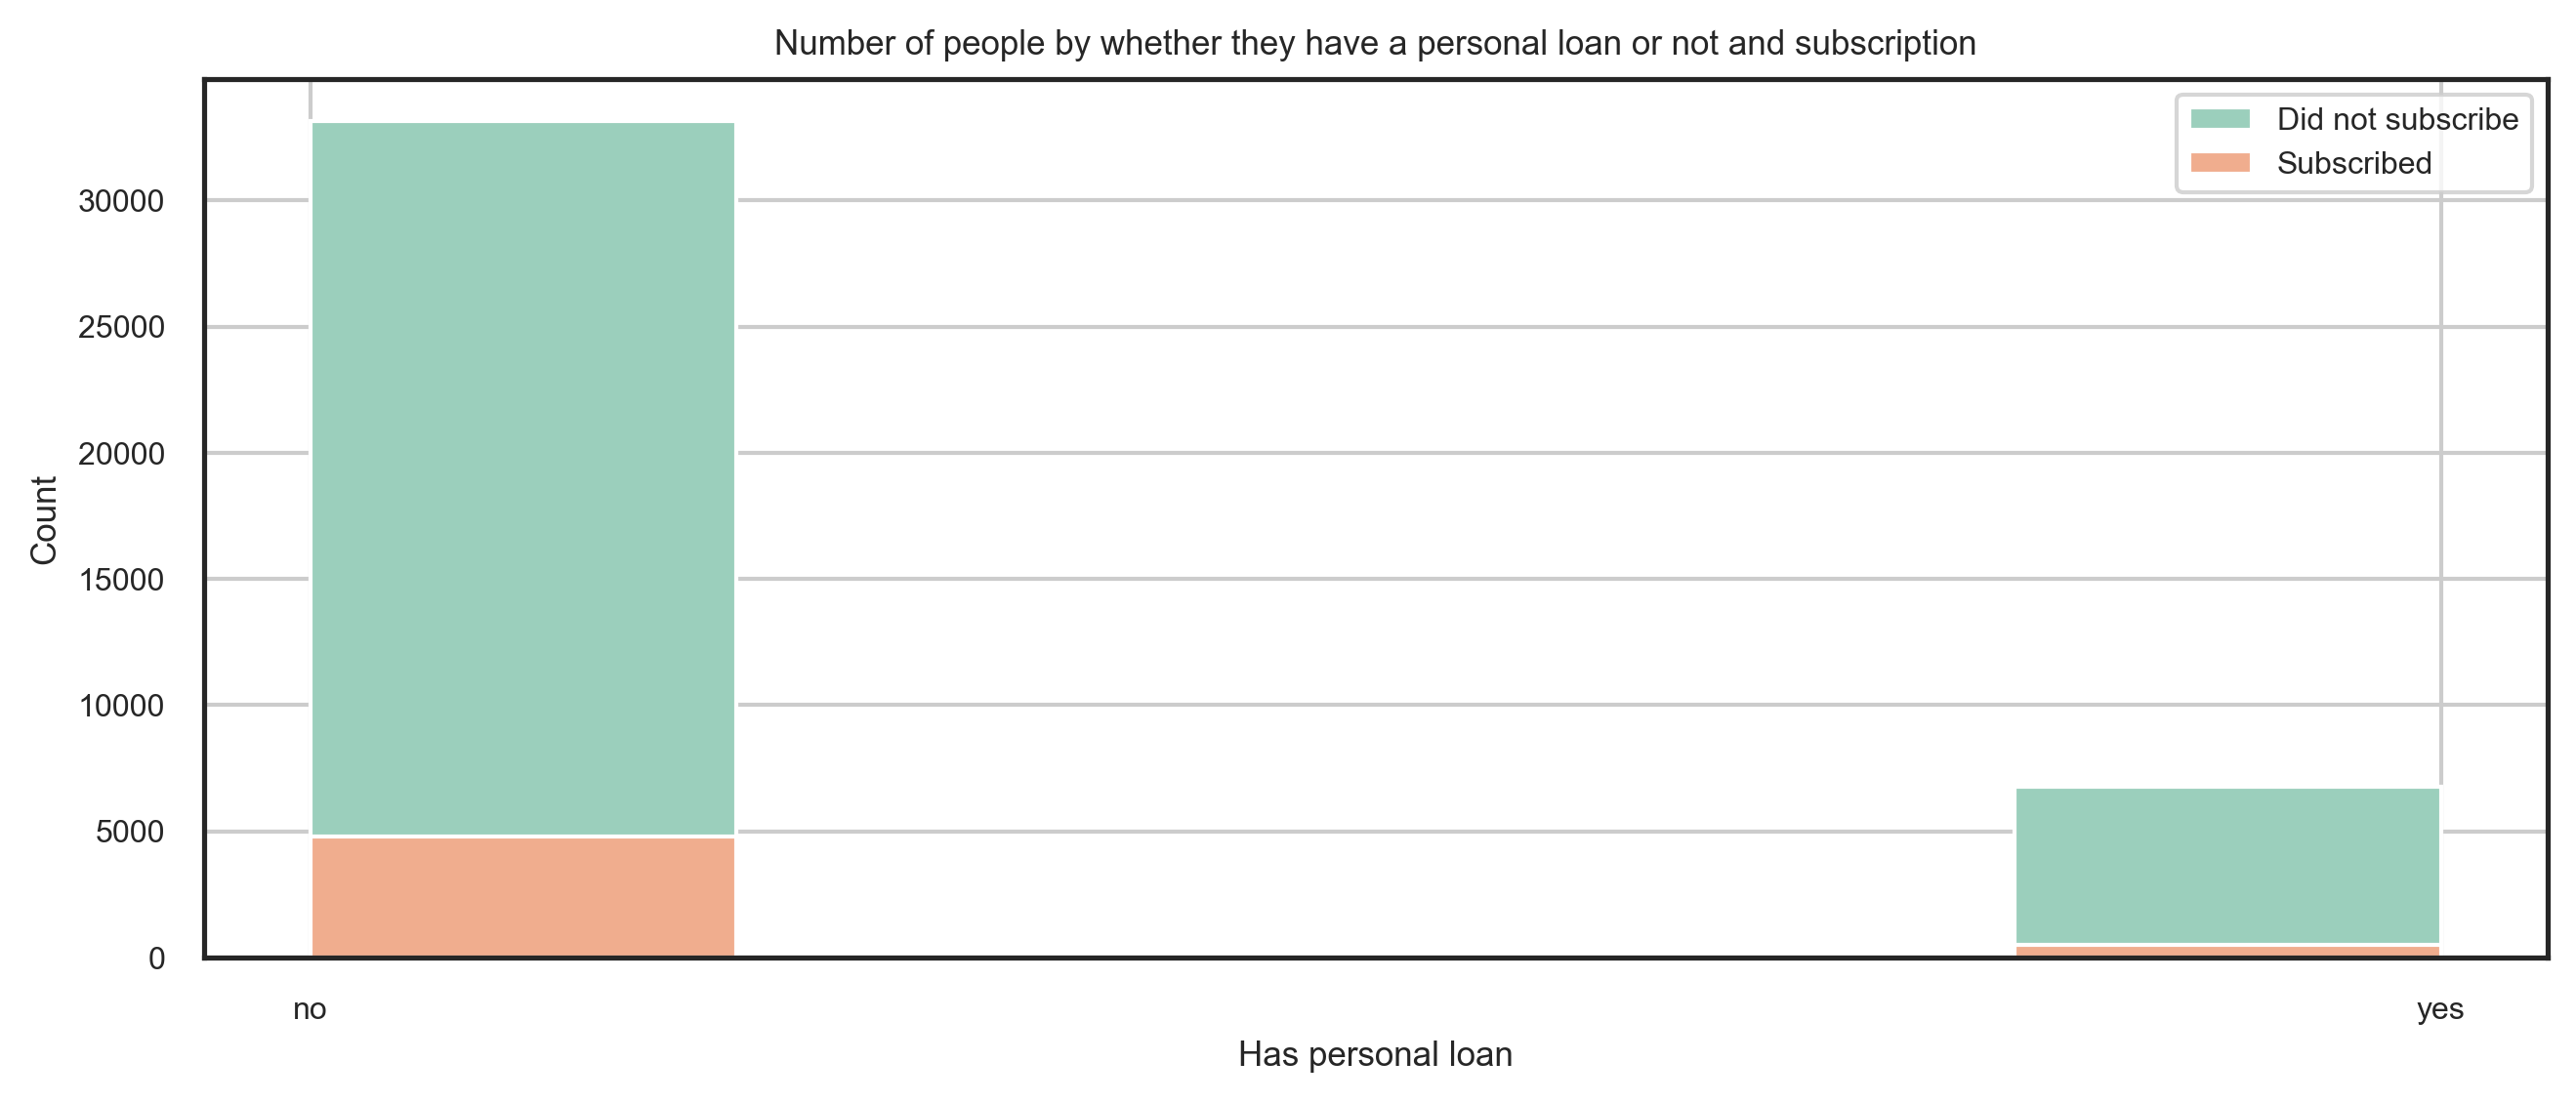

In [30]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_axes([0, 0, 1, 1])

df[df['y'] == 0]['loan'].hist(color ='#9BCFBC', bins = 5, label = 'Did not subscribe')
df[df['y'] == 1]['loan'].hist(color ='#F0AD8E', bins = 5, label = 'Subscribed')

plt.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Has personal loan')
ax.set_title("Number of people by whether they have a personal loan or not and subscription")

It seems we have the profile of people the bank should be focusing their marketing campagin on: people with tertiary education, current students, retired and older people, people without a personal loan... as well as an idea of which months and days they should be called in order to increase the amount of buyers. Next, we will focus on getting the data ready for modeling.

## Data Cleaning and Preprocessing

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45211 entries, 27859 to 27727
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          45211 non-null  int64   
 1   job          44923 non-null  object  
 2   marital      45211 non-null  object  
 3   education    43354 non-null  object  
 4   default      45211 non-null  object  
 5   balance      45211 non-null  int64   
 6   housing      45211 non-null  object  
 7   loan         45211 non-null  object  
 8   contact      32191 non-null  object  
 9   day_of_week  45211 non-null  int64   
 10  month        45211 non-null  category
 11  duration     45211 non-null  int64   
 12  campaign     45211 non-null  int64   
 13  pdays        45211 non-null  int64   
 14  previous     45211 non-null  int64   
 15  poutcome     8252 non-null   object  
 16  y            45211 non-null  int64   
dtypes: category(1), int64(8), object(8)
memory usage: 5.9+ MB


Here we can see our data types, as well as have a hint as to which variables have missing values. We are going to take care of these a bit later. First, let's check for outliers.

In [32]:
df.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


For our numerical features, we can already check there are at least some outliers. All features, except for 'age' and 'day_of_week' (predictably), might suffer from outliers, with quantities jumping abnormally from the mean to the max, as well as from the 75th percentile to the max. Let's visualize some relationships.

Text(0.5, 1.0, 'Correlation Heatmap')

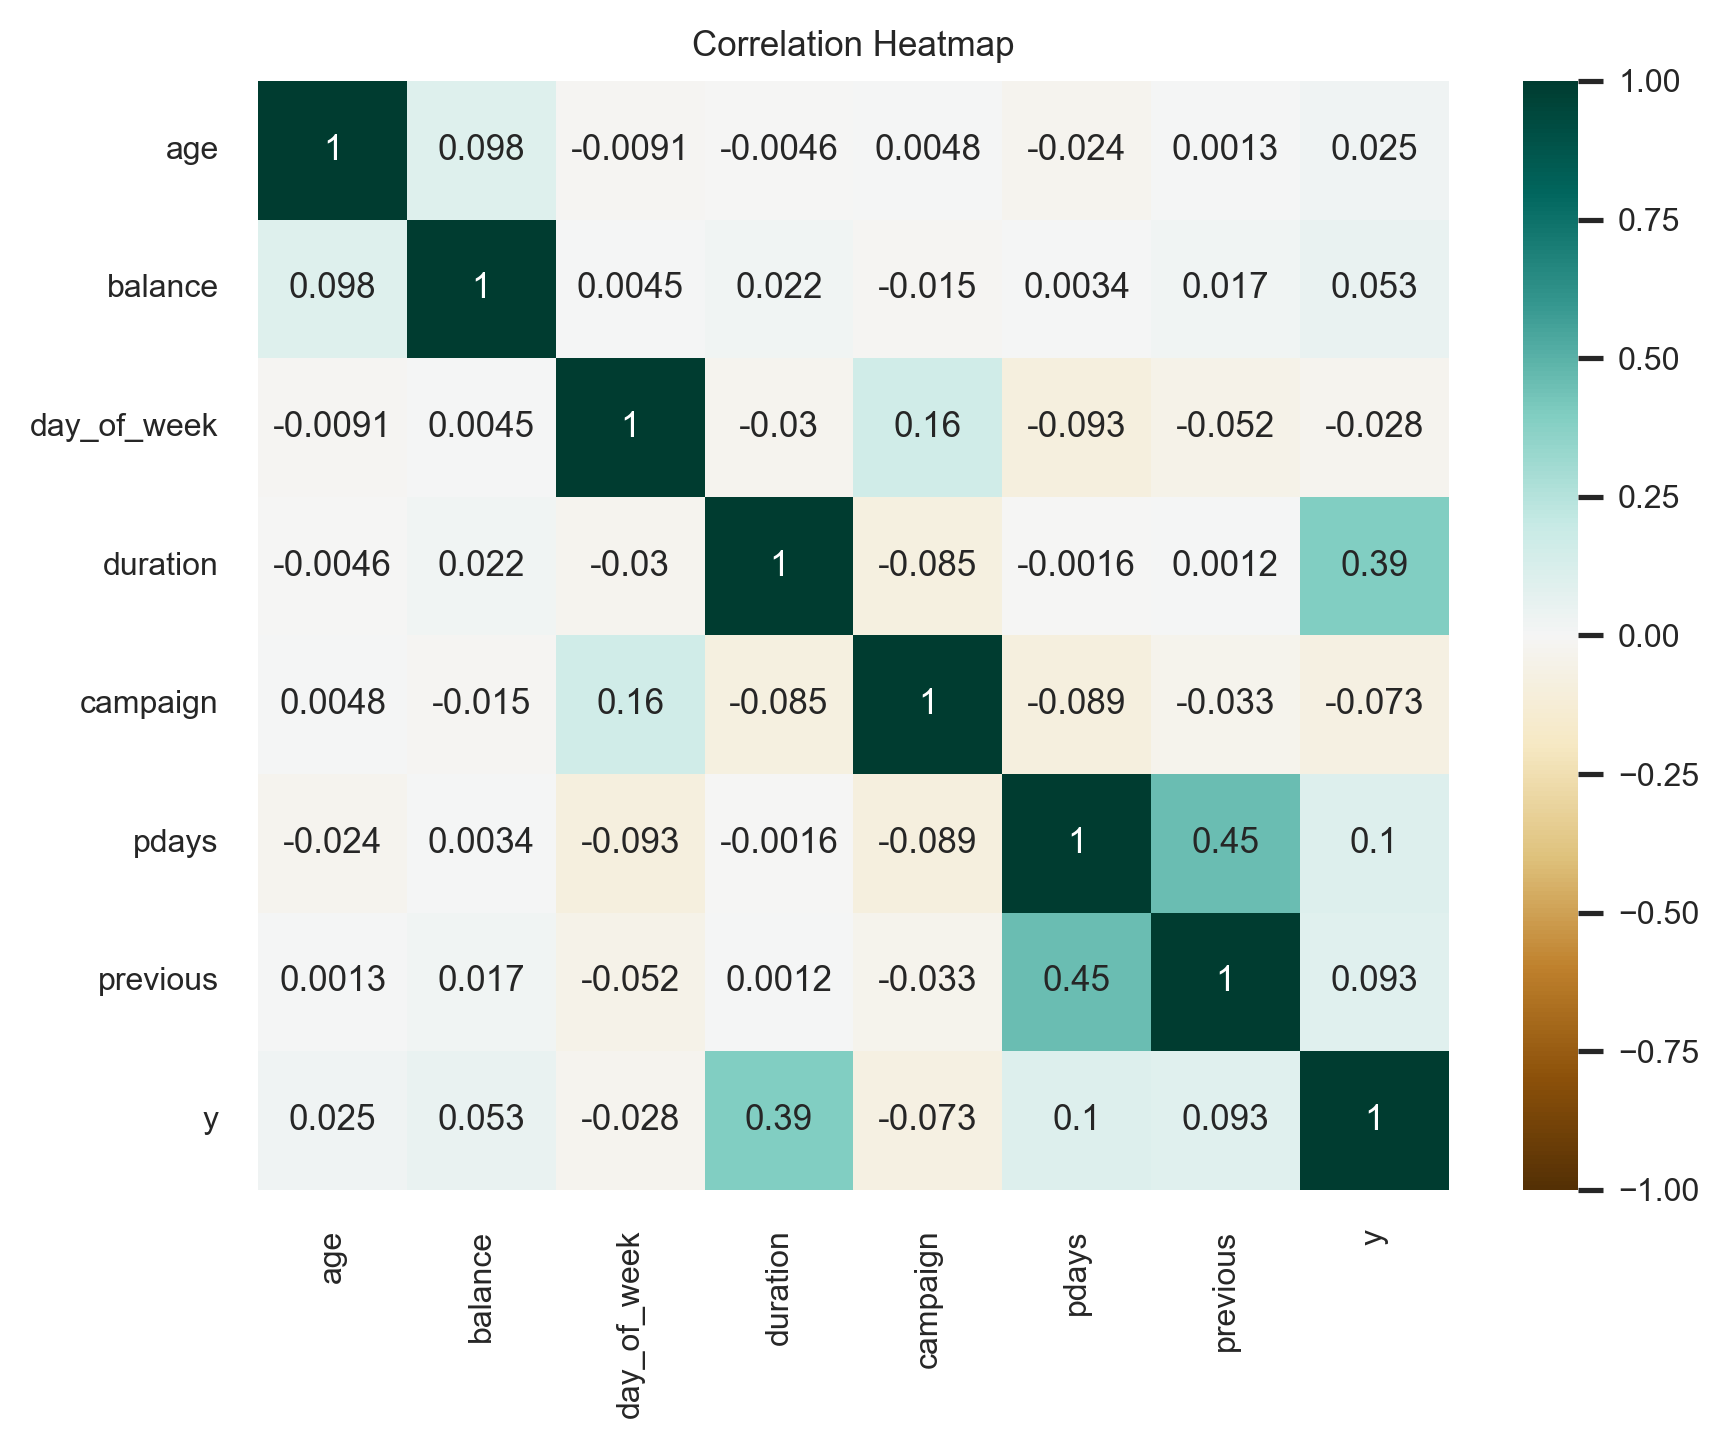

In [33]:
numeric_cols = df.select_dtypes("number").columns
sns.heatmap(df[numeric_cols].corr(), vmin=-1, vmax=1, annot = True, cmap = 'BrBG').set_title('Correlation Heatmap')

The variables seem to have low correlation, making them hard to group together.

KeyboardInterrupt: 

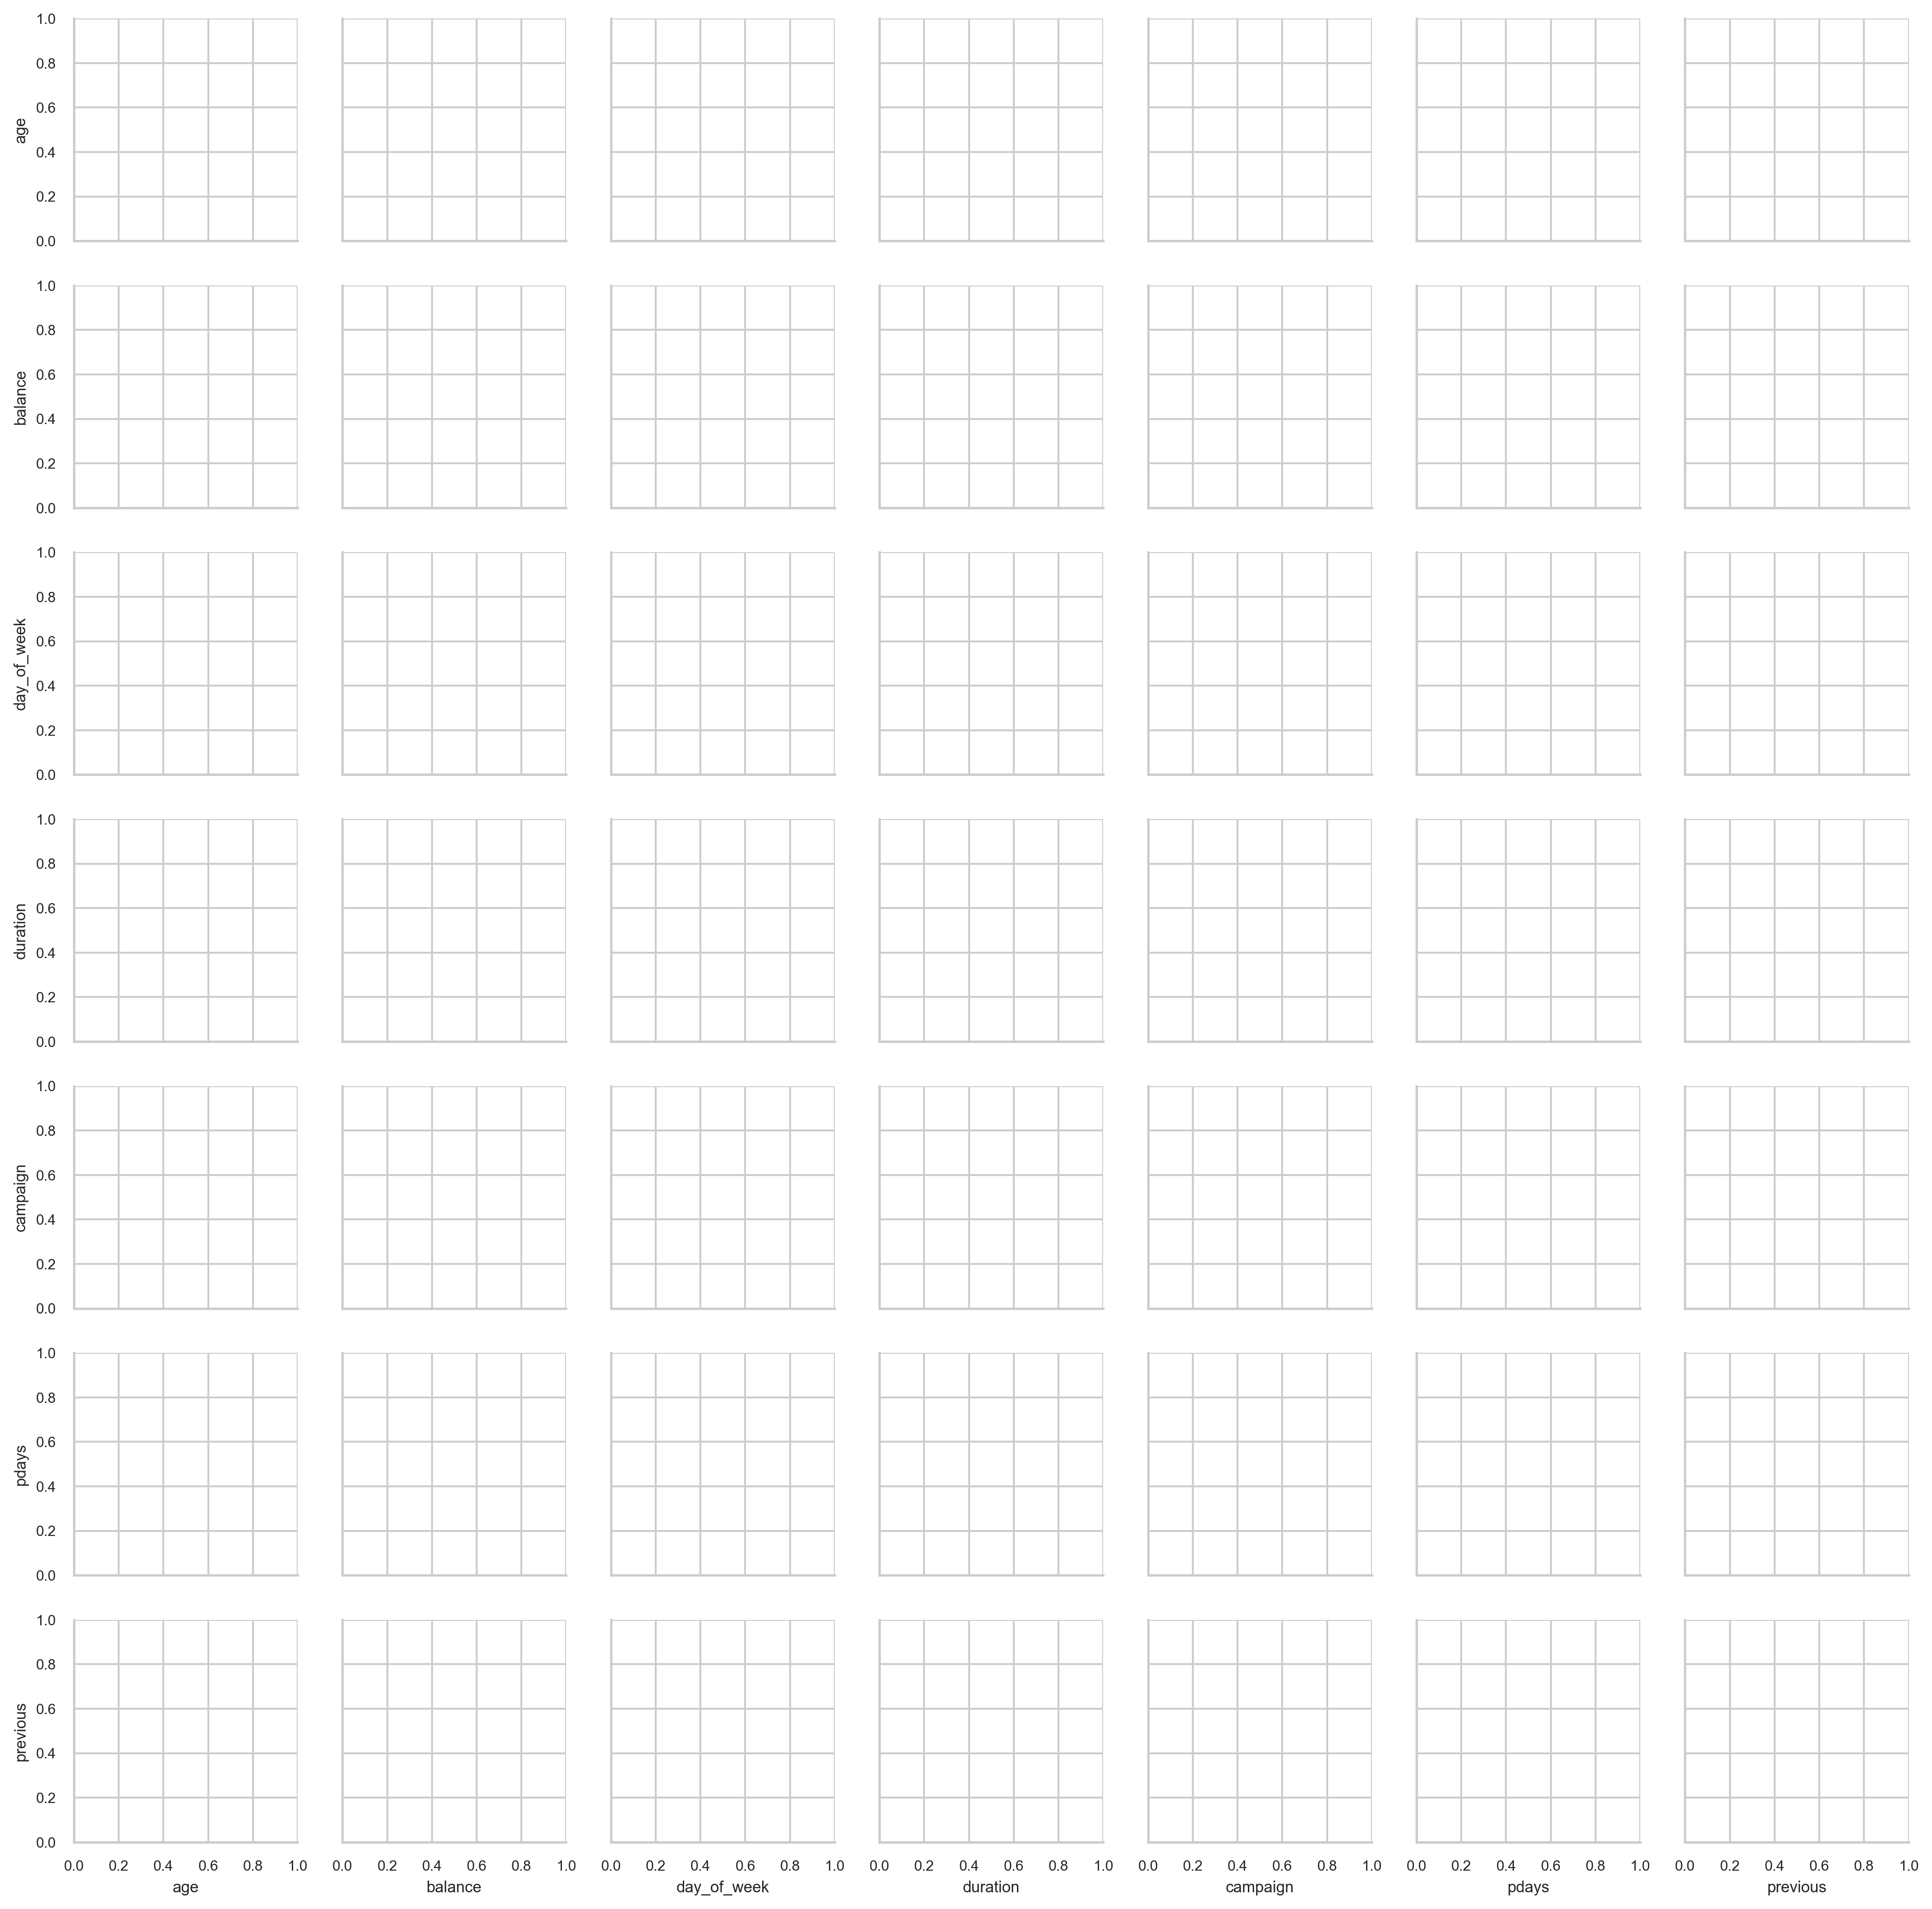

In [34]:
sns.set_style('whitegrid')
sns.pairplot(df, hue = 'y', palette = 'coolwarm')

There are also some notable cases in these outlier-holding variables. Mainly, 'previous' seems to have only one outlier. Let's stop working with 'age' and 'days of week' and have a closer look. 

<Axes: xlabel='previous', ylabel='Count'>

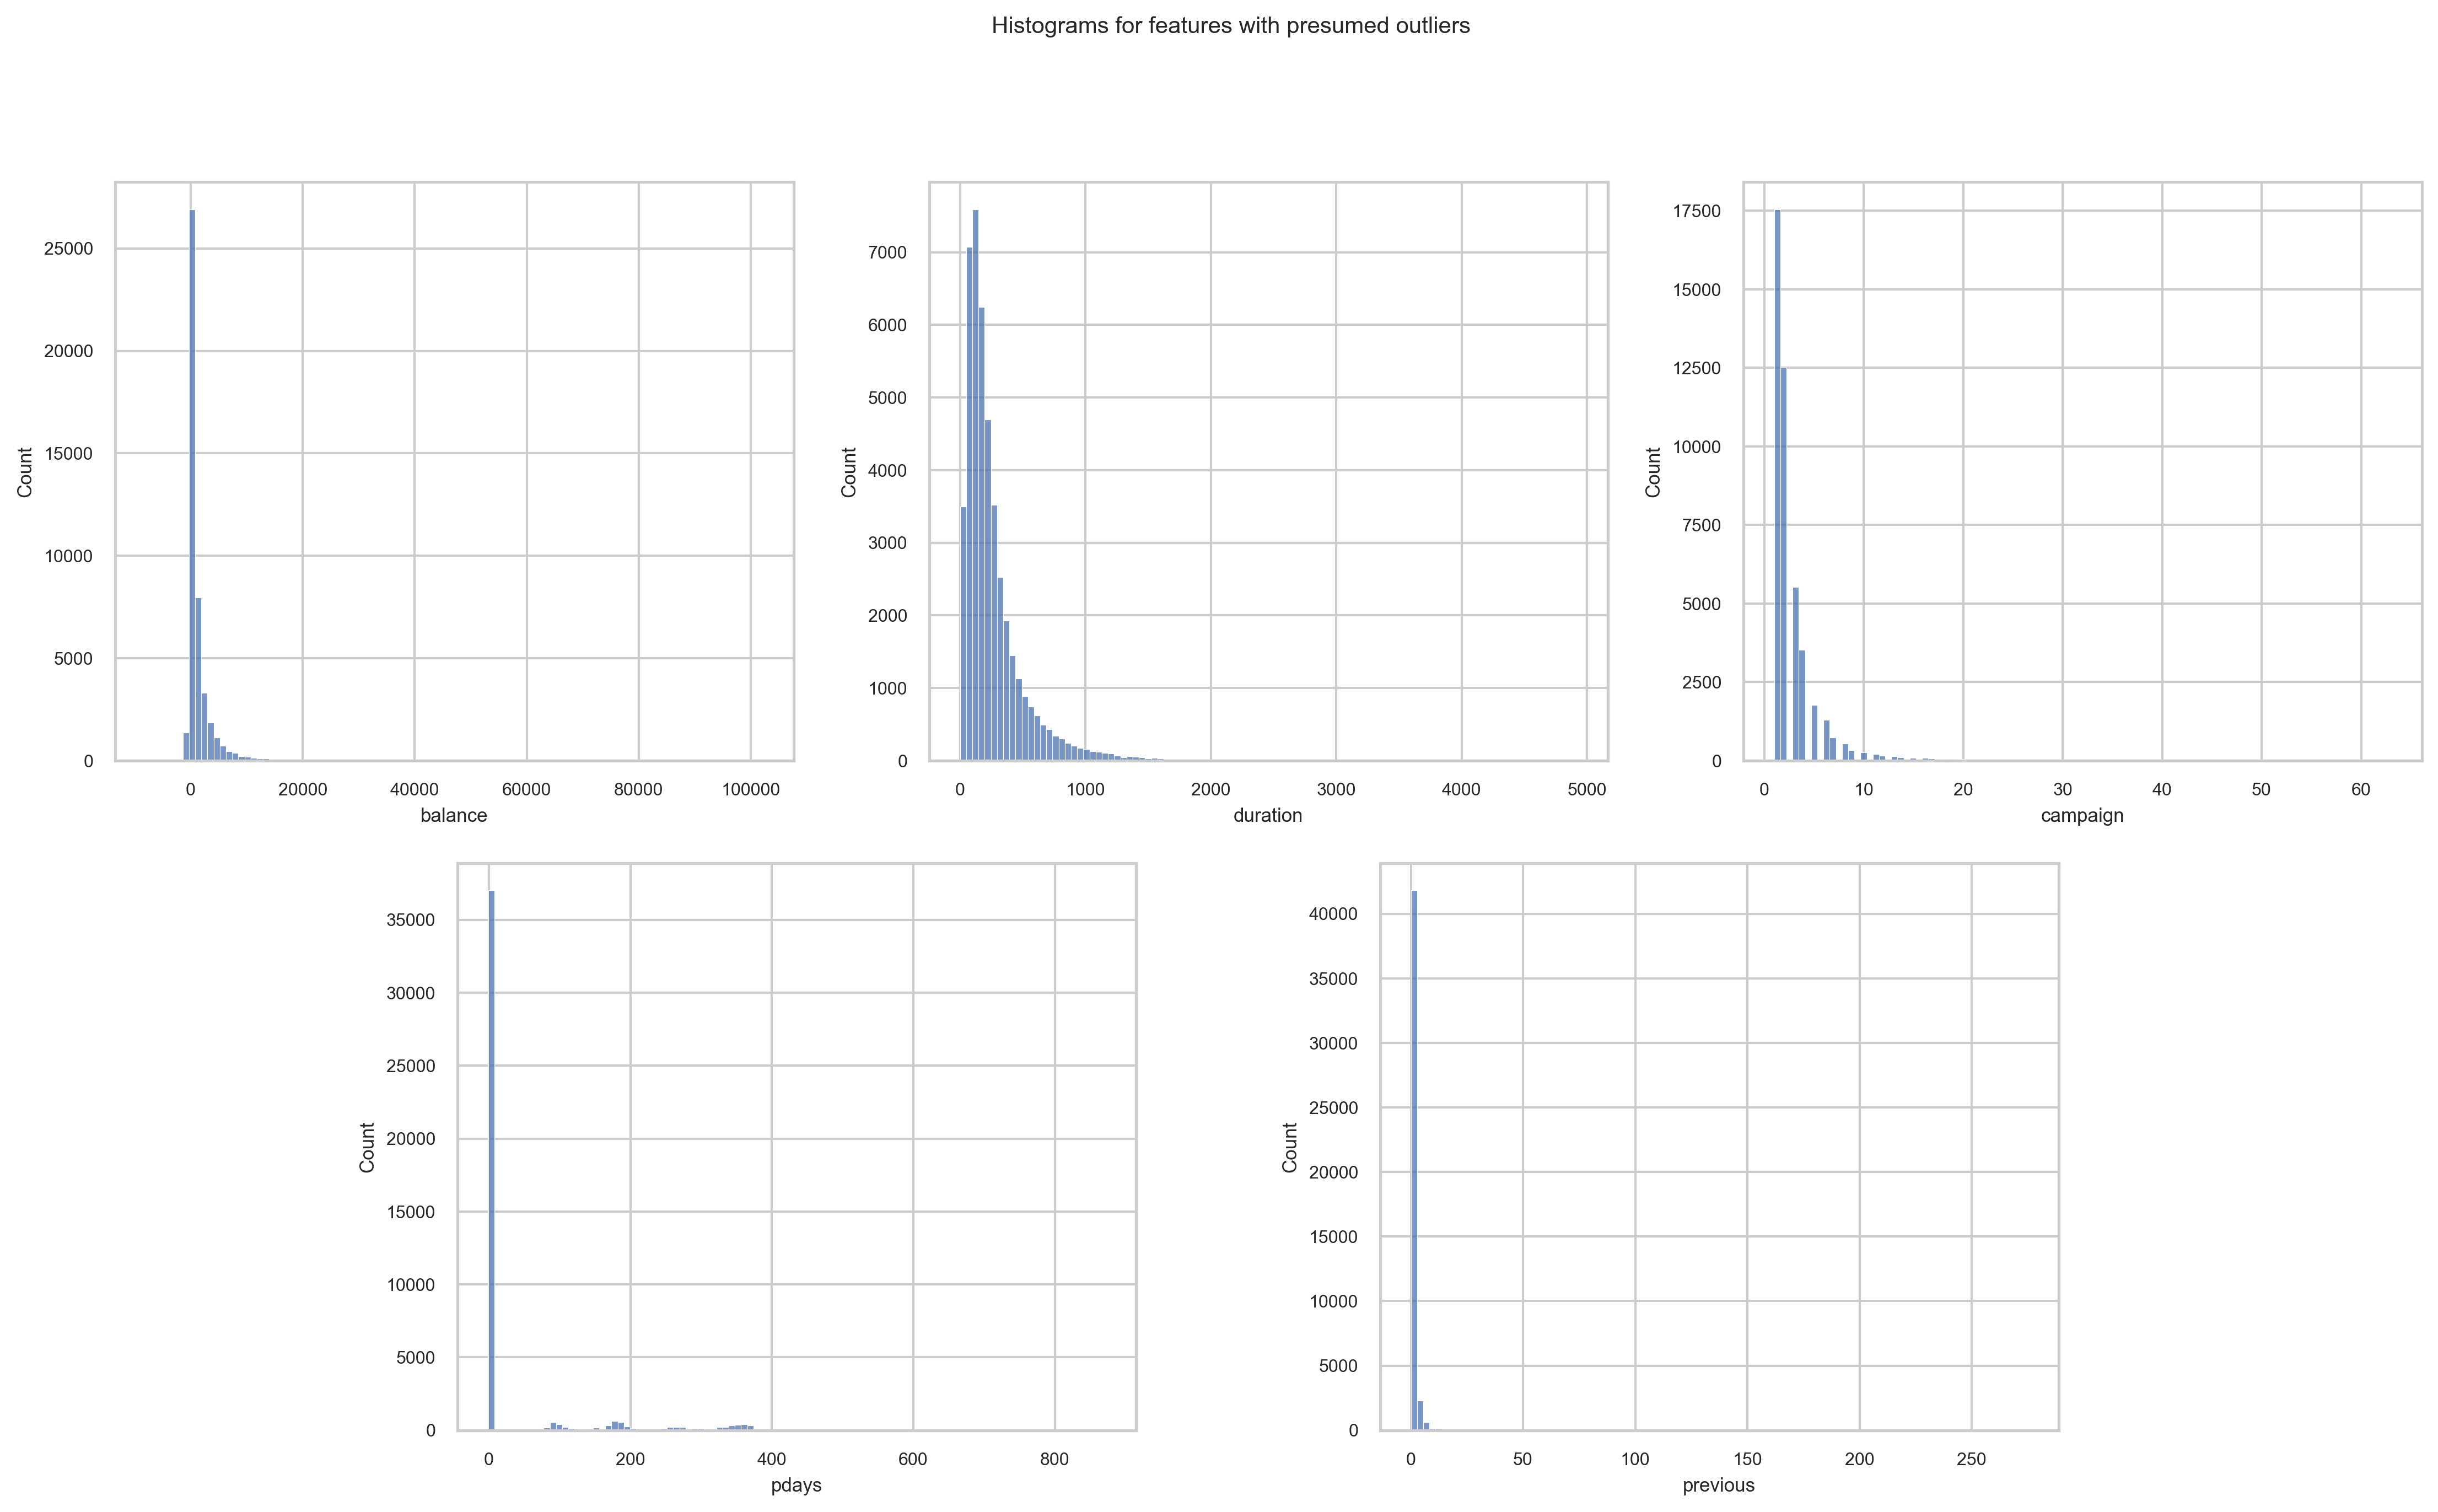

In [36]:
outlier_df = df[numeric_cols].drop(['age', 'day_of_week'], axis = 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Histograms for features with presumed outliers')

axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])

sns.histplot(ax=axes[0, 0], data = outlier_df, x = 'balance', bins = 100)
sns.histplot(ax=axes[0, 1], data = outlier_df, x = 'duration', bins = 100)
sns.histplot(ax=axes[0, 2], data = outlier_df, x = 'campaign', bins = 100)
sns.histplot(ax=axes[1, 0], data = outlier_df, x = 'pdays', bins = 100)
sns.histplot(ax=axes[1, 1], data = outlier_df, x = 'previous', bins = 100)

<Axes: ylabel='previous'>

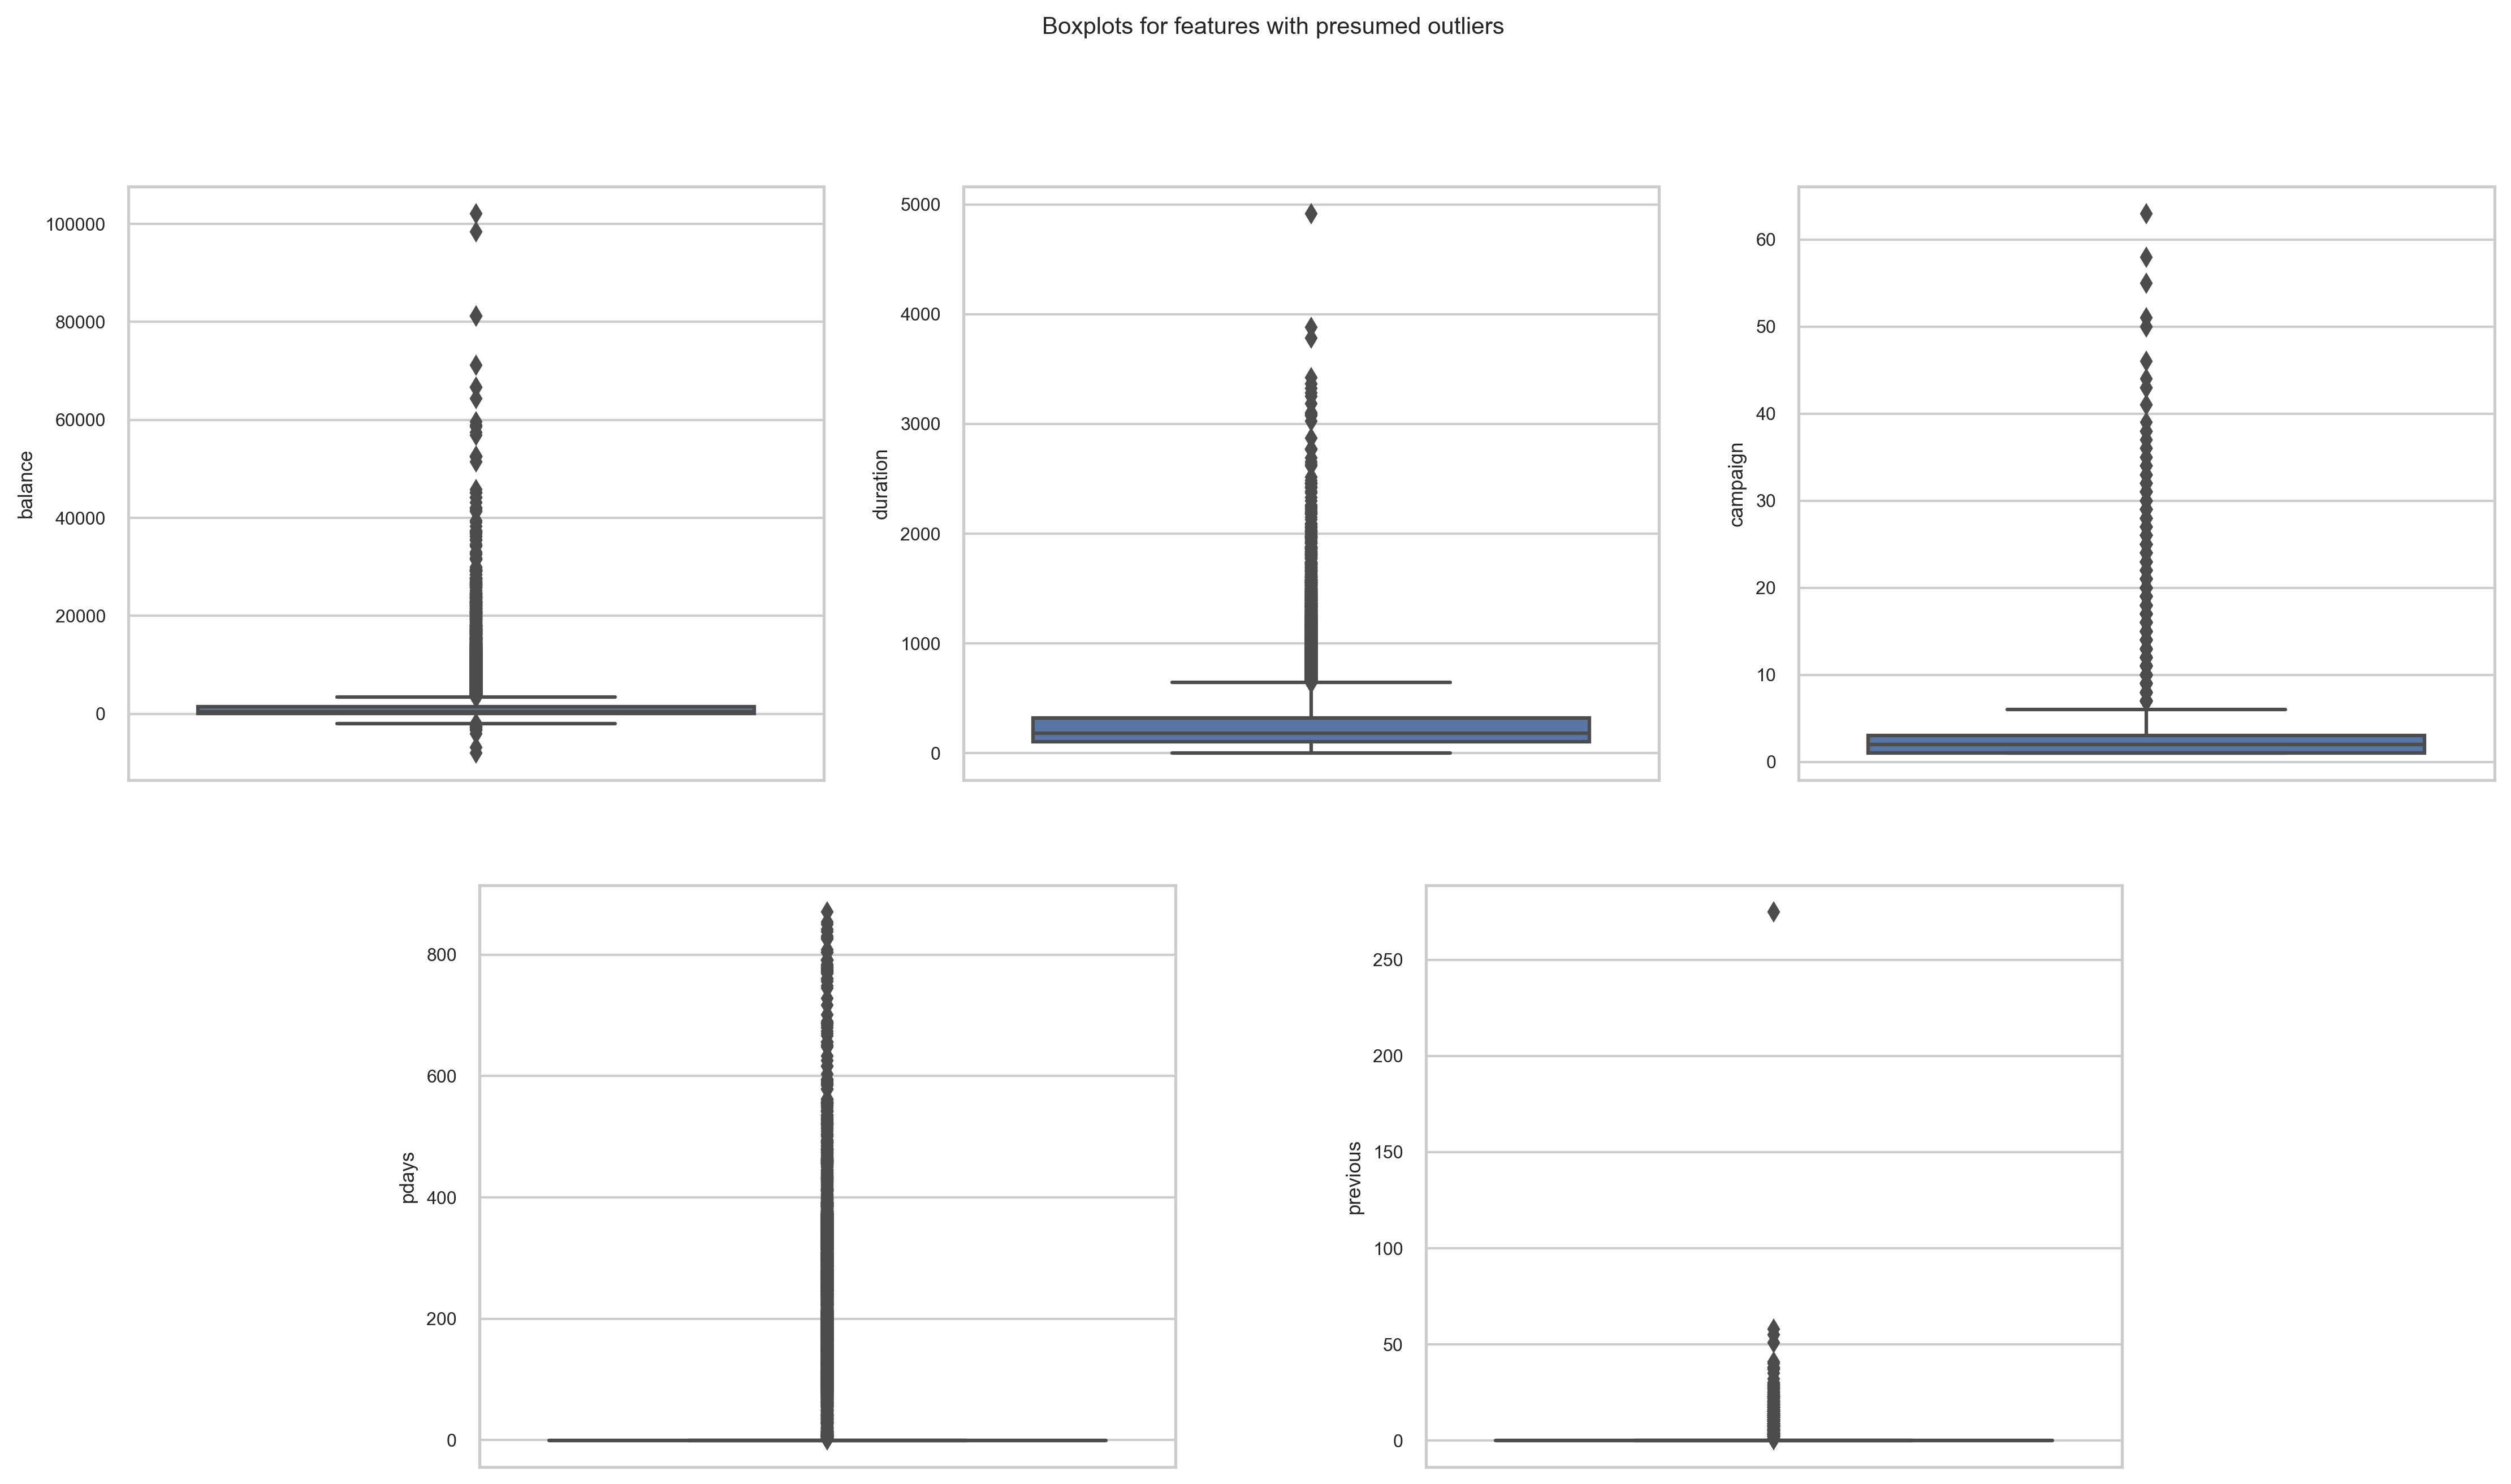

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Boxplots for features with presumed outliers')

axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])

sns.boxplot(ax=axes[0, 0], data = outlier_df, y = 'balance')
sns.boxplot(ax=axes[0, 1], data = outlier_df, y = 'duration')
sns.boxplot(ax=axes[0, 2], data = outlier_df, y = 'campaign')
sns.boxplot(ax=axes[1, 0], data = outlier_df, y = 'pdays')
sns.boxplot(ax=axes[1, 1], data = outlier_df, y = 'previous')

Although the boxplot (and our initial analysis) indicate a wide range of values outside the interquartile range, it might not mean much if these variables are not normally distributed (as we have seen from the histograms and kde's). We can proceed to manually get rid of the observations with the farthest values manually, placing a 'cap' on our features.

In [39]:
df2 = df[(df["balance"] < 80000) & (df["duration"] < 3500) & (df["campaign"] < 50) & (df["previous"] < 50)] #saving as separate dataframe to use the original for further analysis

Although this is our first solution, we will later use WoE transformation to better deal with both outliers and missing values. Now, let's check for missing values with the following code, as well as a heatmap to visualize it better.

In [40]:
df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

<Axes: >

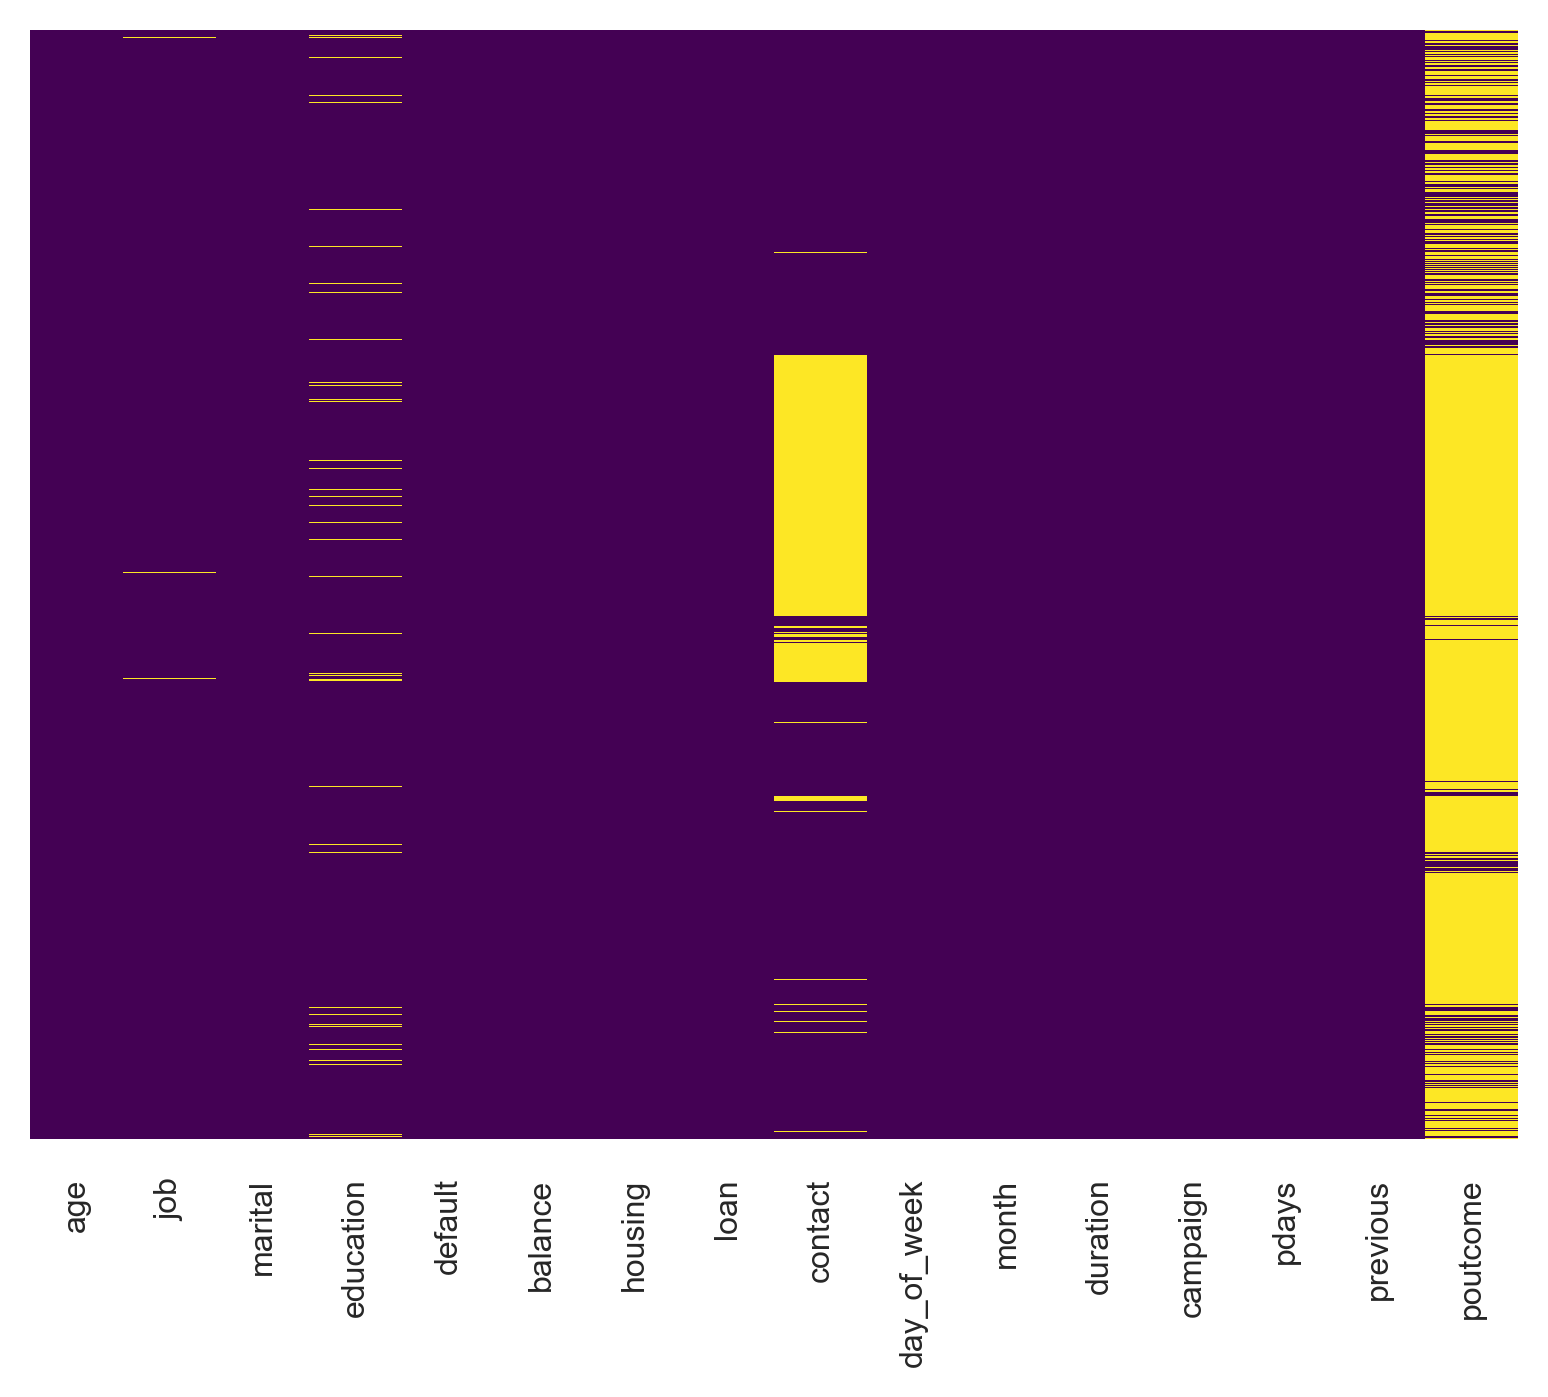

In [41]:
sns.heatmap(df.drop('y', axis = 1).isnull(),yticklabels=False,cbar=False,cmap='viridis')

Before we jump to WoE, we will first try to impute the missing values using certain rules and the mode (we will call this df2), and we will also remove records with missing values (and this one df3) and keep it as alternative datasets we can try for modeling later on. 'poutcome' and 'contact' might have too many missing values to keep around, but we might be able to impute the ones in 'job' and 'education'.

In [42]:
print(df2['job'].value_counts())
print(df2['education'].value_counts())

job
blue-collar      9729
management       9451
technician       7593
admin.           5171
services         4153
retired          2262
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: count, dtype: int64
education
secondary    23194
tertiary     13295
primary       6849
Name: count, dtype: int64


Text(0.5, 0, 'job')

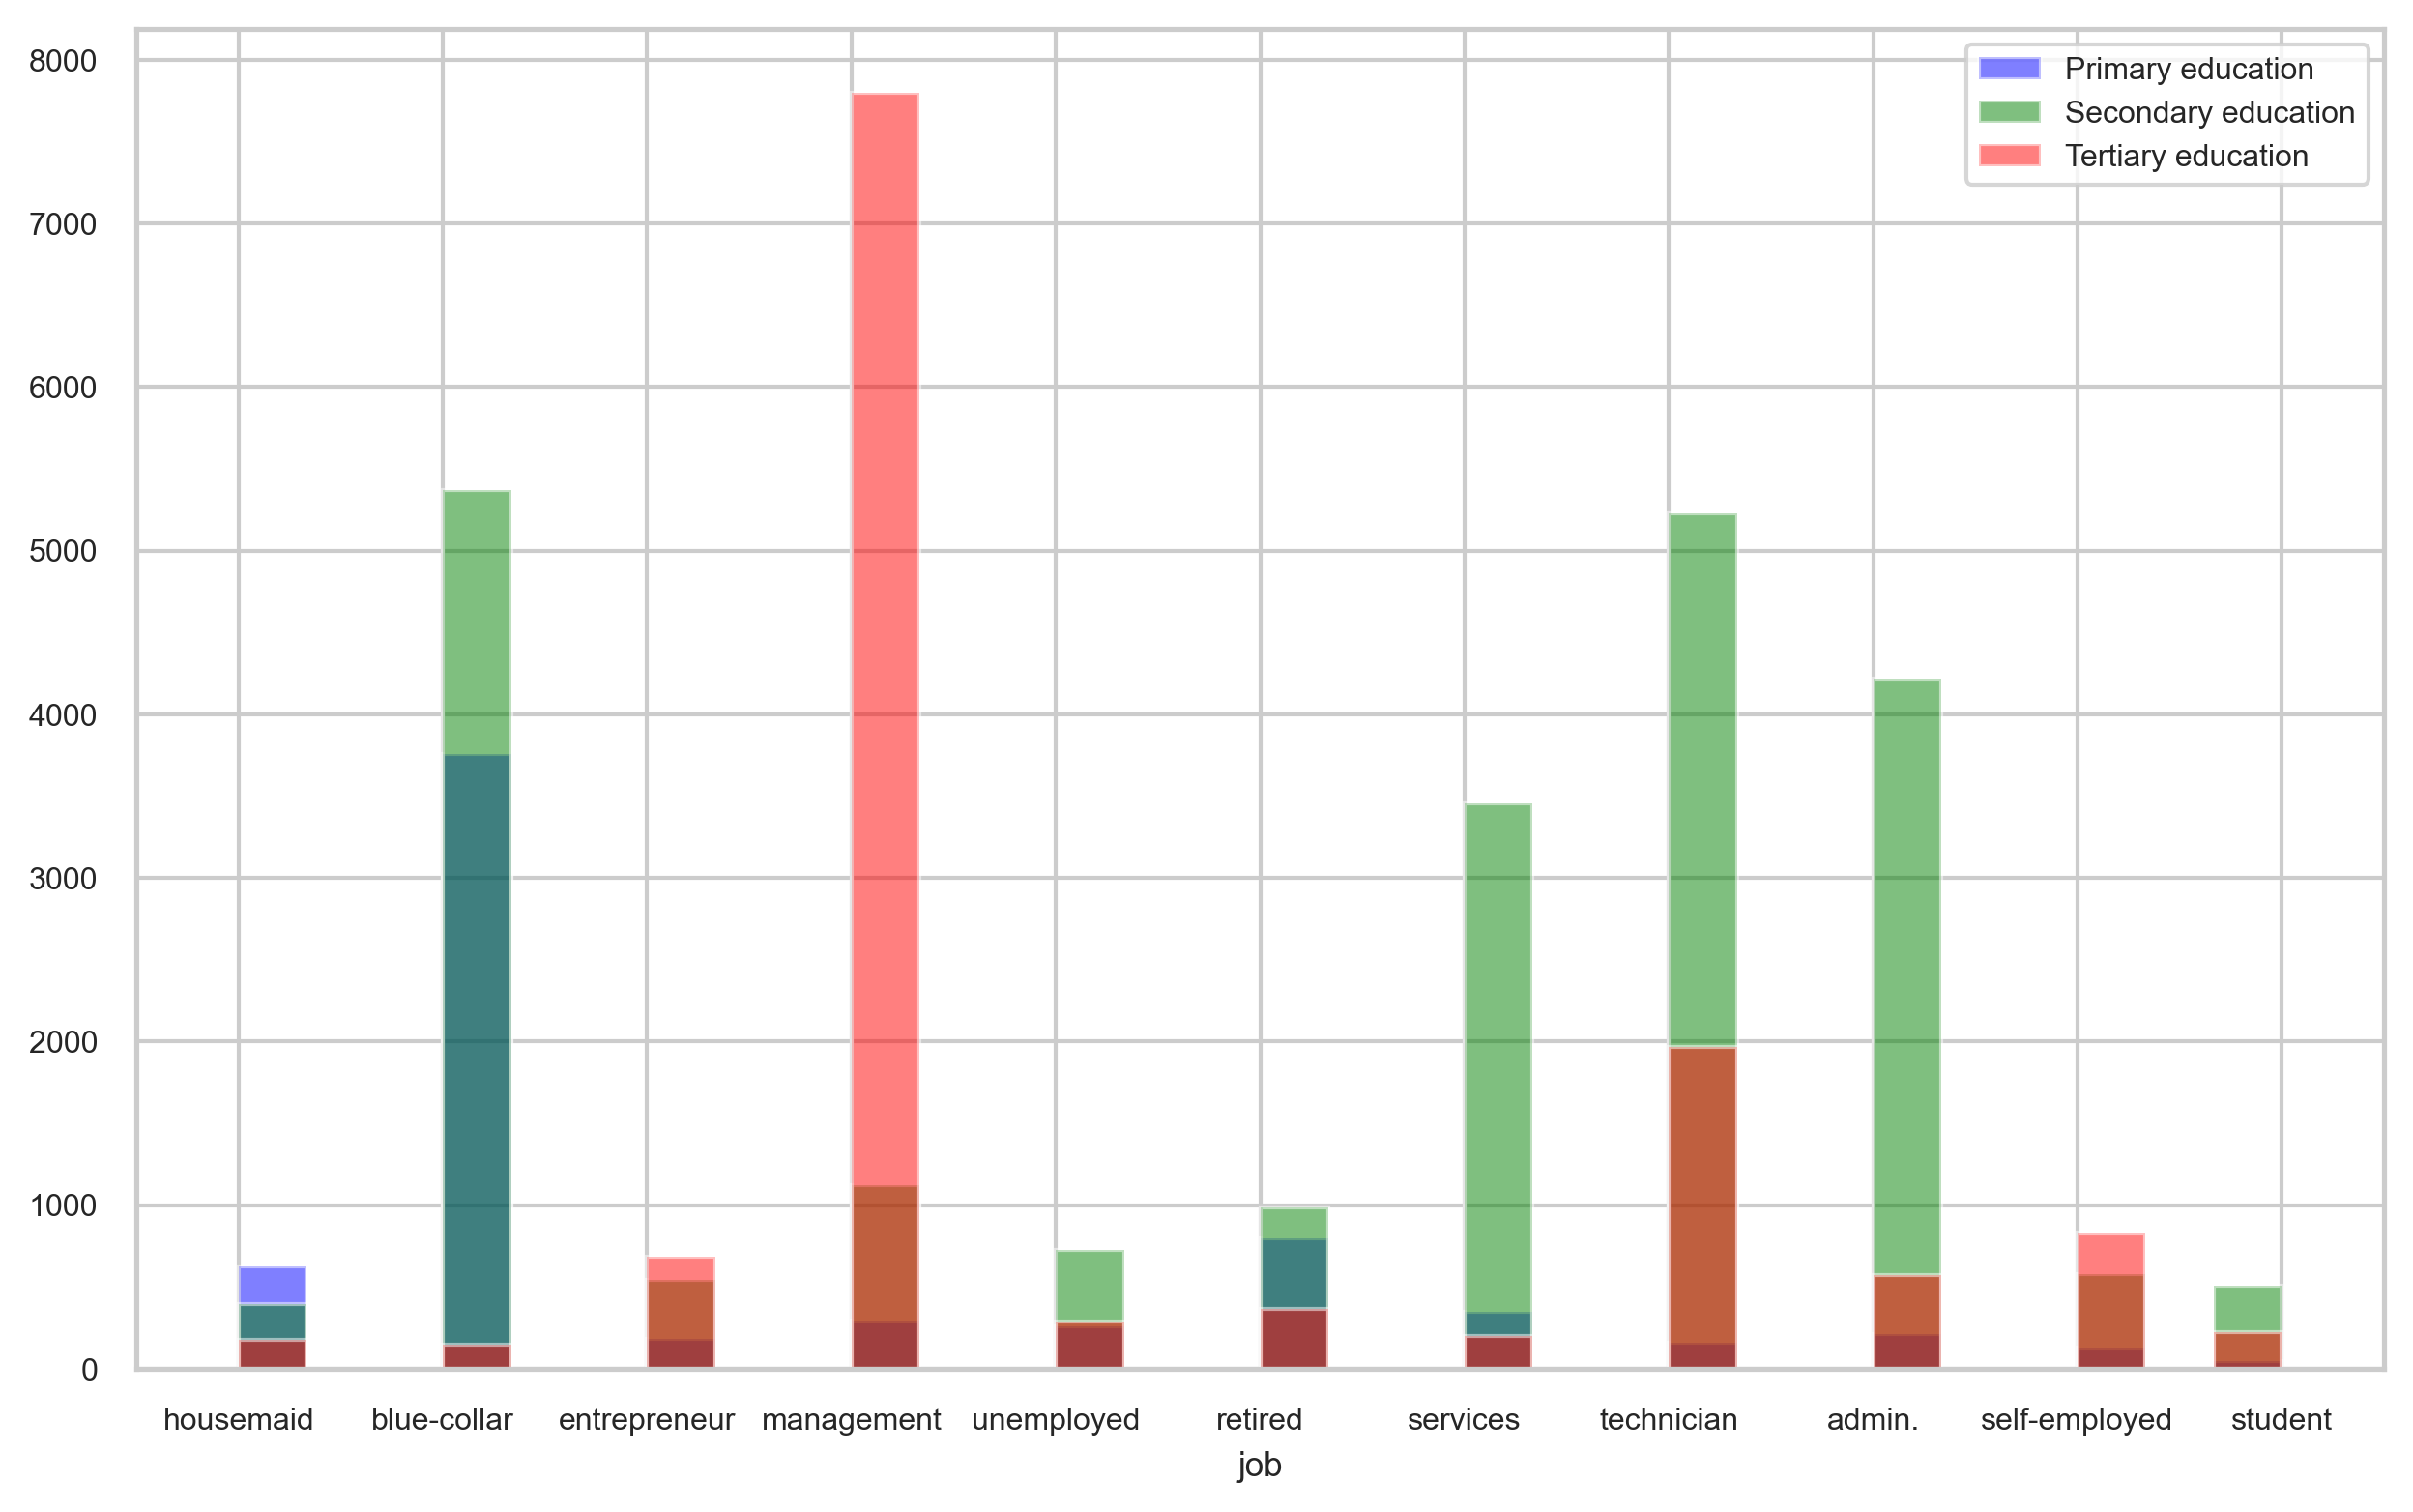

In [43]:
plt.figure(figsize=(10,6))
df[df['education']=='primary']['job'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Primary education')
df[df['education']=='secondary']['job'].hist(alpha=0.5,color='green',
                                              bins=30,label='Secondary education')
df[df['education']=='tertiary']['job'].hist(alpha=0.5,color='red',
                                              bins=30,label='Tertiary education')
plt.legend()
plt.xlabel('job')

The amount of people with tertiary education in management is overwhelming! We might be able to leverage this instead of simply replacing all values with the mode. The same goes for the proportion with primary education in housemaid.

In [44]:
def education_filler(row):
    if row['job'] == 'management':
        return 'tertiary'
    elif row['job'] == 'housemaid':
        return 'primary'
    else:
        return 'secondary' # mode replacement. secondary education is the most common value.

df2['education'][df2['education'].isnull() == True] = df2.apply(education_filler, axis = 1)

C:\Users\ianpv\AppData\Local\Temp\ipykernel_119540\838612309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['education'][df2['education'].isnull() == True] = df2.apply(education_filler, axis = 1)


<Axes: xlabel='age', ylabel='Density'>

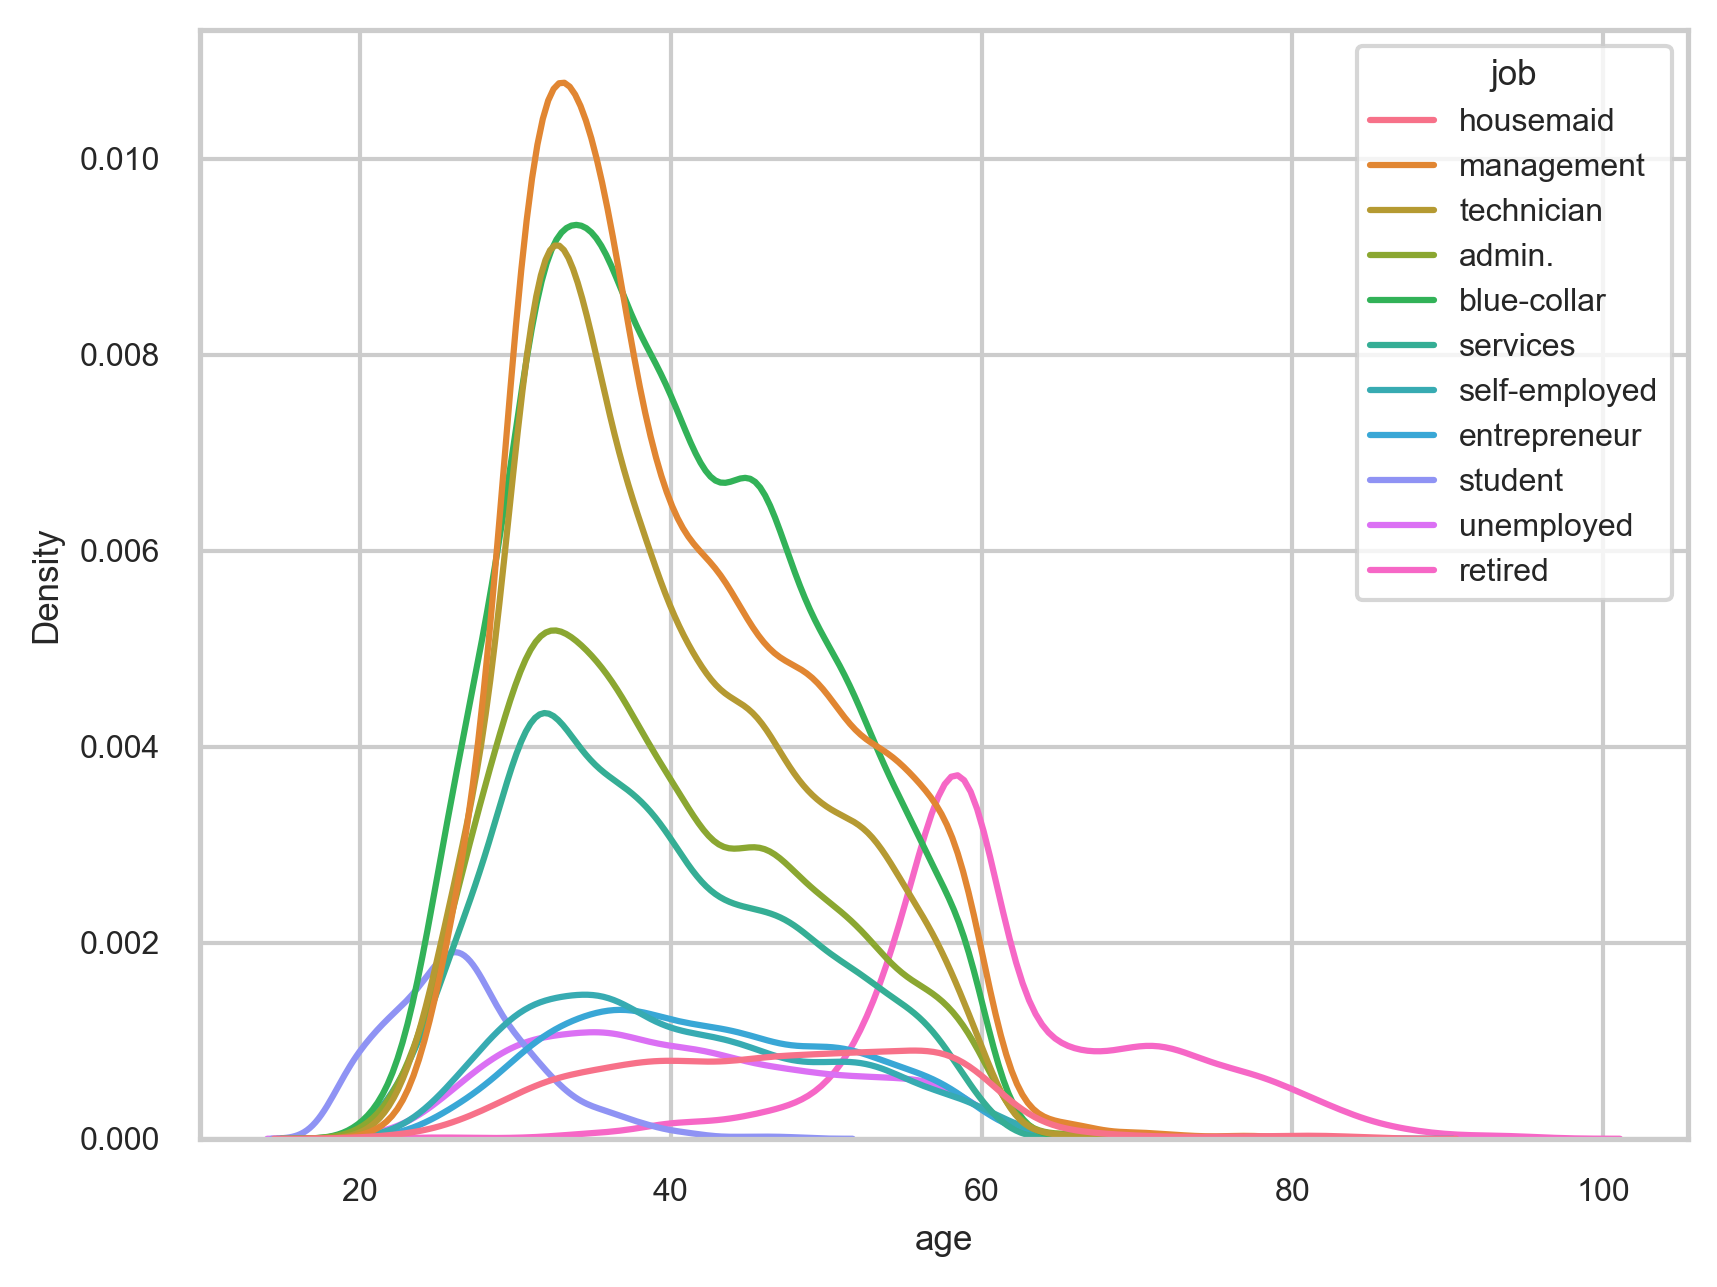

In [45]:
sns.kdeplot(df2, x = 'age', hue = 'job')

Similarly, we might be able to derive some conclusions about our missing values on 'job' from the age of our subjects. People below 22 years old tend to be students, while people over 60 tend to be retired by a large margin.

In [46]:
def job_filler(row):
    if row['age'] <= 22:
        return 'student'
    elif row['age'] >= 60:
        return 'retired'
    else:
        return 'blue-collar' # mode replacement.

df2['job'][df2['job'].isnull() == True] = df2.apply(job_filler, axis = 1)

C:\Users\ianpv\AppData\Local\Temp\ipykernel_119540\4068147526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['job'][df2['job'].isnull() == True] = df2.apply(job_filler, axis = 1)


Let's check our heatmap now.

<Axes: >

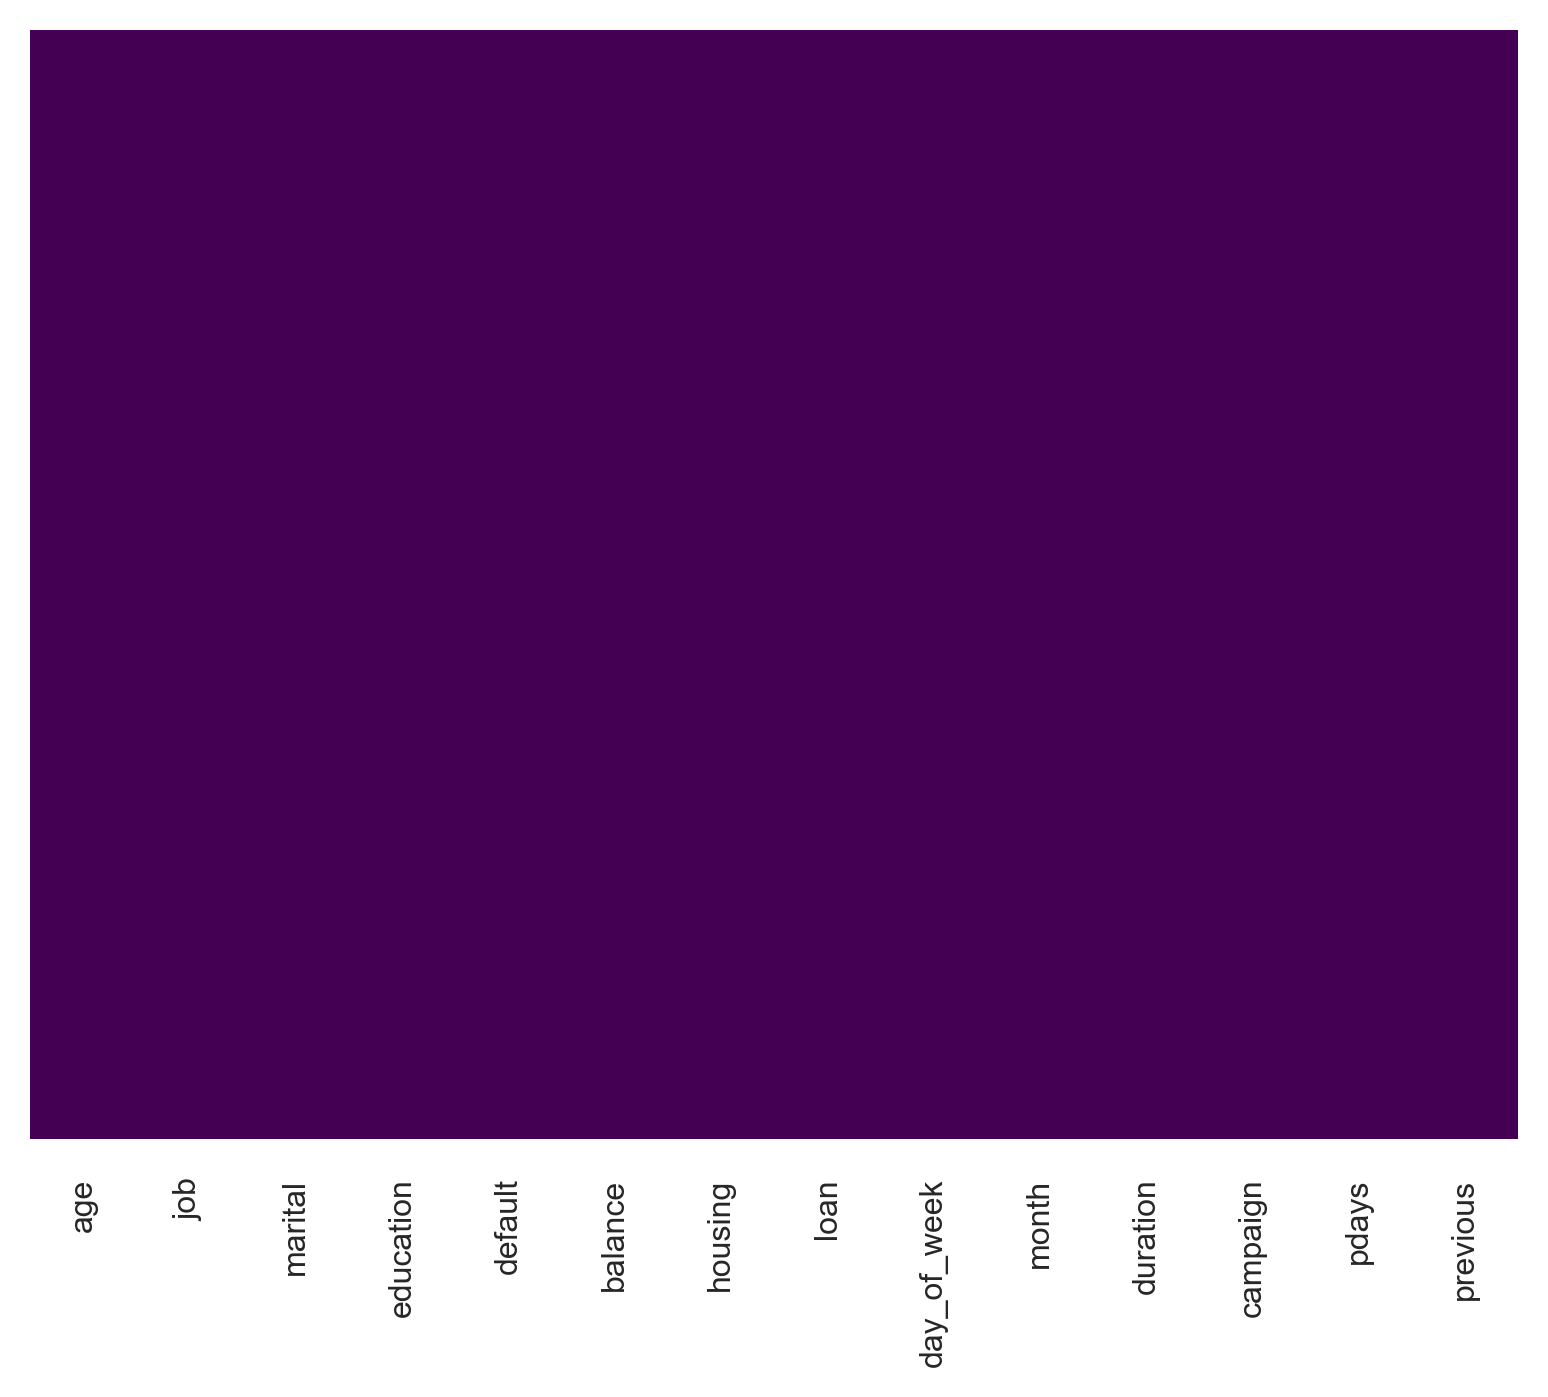

In [47]:
sns.heatmap(df2.drop(['y', 'contact', 'poutcome'], axis = 1).isnull(),yticklabels=False,cbar=False,cmap='viridis')

We have imputed all missing values based on our conditions. Let's try the next approach of deleting all these instances where missing values on 'age' and 'job' exist. Let's also cap the values to get rid of outliers as we did with df2.

In [53]:
df3 = df[(df["balance"] < 80000) & (df["duration"] < 3500) & (df["campaign"] < 50) & (df["previous"] < 50)]
df3 = df.drop(['contact', 'poutcome'], axis = 1).dropna()
print(f'Obsservations lost: {len(df) - len(df3)}')

Obsservations lost: 2018


<Axes: >

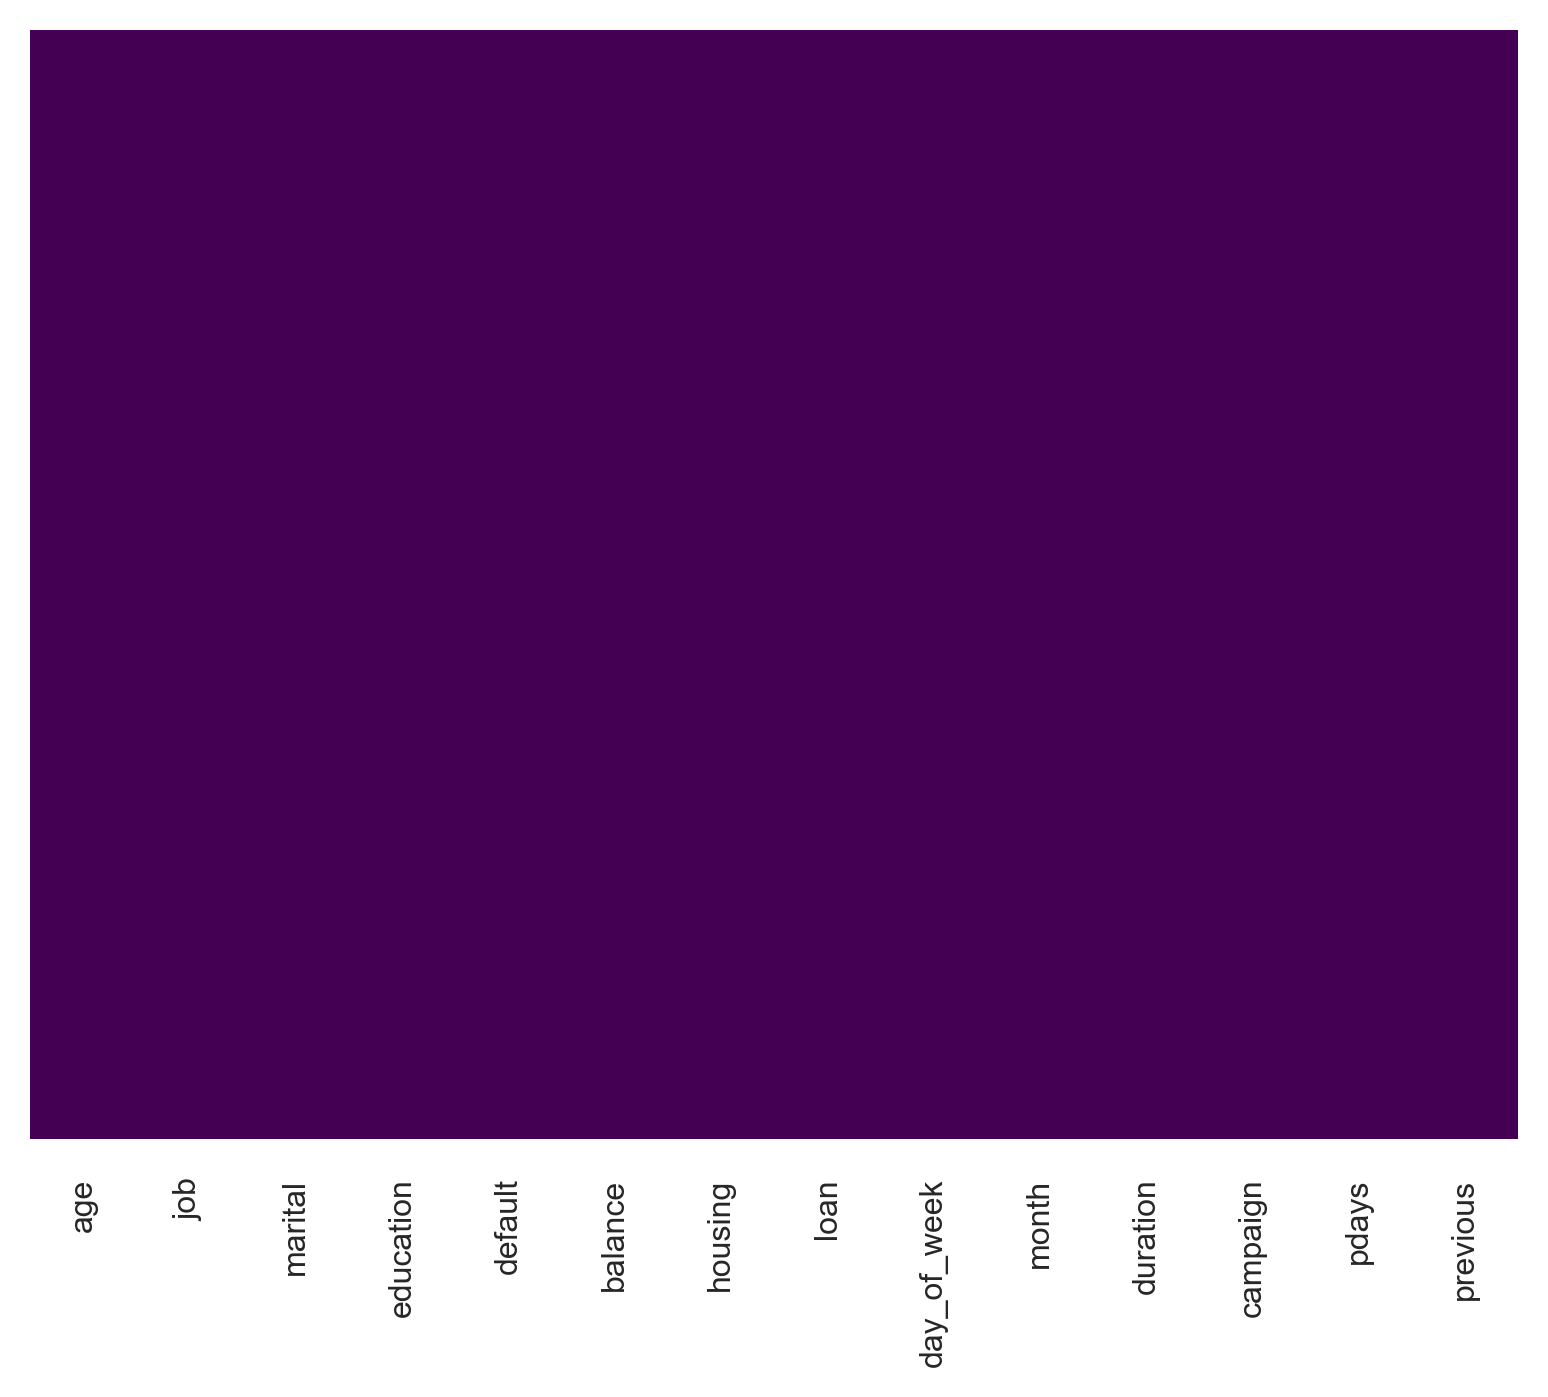

In [54]:
sns.heatmap(df3.drop(['y'], axis = 1).isnull(),yticklabels=False,cbar=False,cmap='viridis')

We have once again successfully dealt with all missing  values, with the downside of losing 2,018 observations. This may not be too taxing on our final product considering our sample size. Now, let's get started with our final Weight of Evidence transformation.

In [ ]:
# One hot encoding to finish setting up df2 and df3
df2 = pd.get_dummies(df2, columns = ['job','marital','education','default','housing','loan','month'], drop_first=True)
df3 = pd.get_dummies(df3, columns = ['job','marital','education','default','housing','loan','month'], drop_first=True)

In [51]:
df['y'].replace(['no', 'yes'],[0, 1], inplace=True) # convert categorical target to numeric

In [52]:
import category_encoders as ce

X_cols = df.drop('y', axis = 1).columns

encoder = ce.WOEEncoder(cols = X_cols)
encoder.fit(df[X_cols], df['y'])
df_woe = encoder.transform(df[X_cols])


df_woe.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,-0.056668,-0.053977,-0.014830,-0.018675,-0.002581,0.262057,-0.072978,-0.023272,-0.135749,-0.039643,-0.125523,-0.484749,-0.025784,-0.099244,-0.073941,-0.108961
std,0.392563,0.375508,0.195783,0.221915,0.087355,0.756433,0.435625,0.257951,0.637470,0.340003,0.556473,1.282815,0.305510,0.568378,0.428904,0.536174
min,-0.454762,-0.522928,-0.162288,-0.337618,-0.647305,-1.910855,-0.462385,-0.613807,-1.137031,-0.566855,-0.608632,-3.097023,-1.930273,-1.589948,-0.618087,-0.272837
25%,-0.242487,-0.310291,-0.162288,-0.115224,0.009254,-0.330405,-0.462385,0.089401,-1.137031,-0.278219,-0.608632,-1.325419,-0.048731,-0.273338,-0.273338,-0.272837
50%,-0.143334,-0.062920,-0.162288,-0.115224,0.009254,0.175144,-0.462385,0.089401,0.280183,-0.039779,-0.157375,-0.416534,-0.048525,-0.273338,-0.273338,-0.272837
75%,-0.062036,0.185873,0.282809,0.287283,0.009254,0.721687,0.414338,0.089401,0.280183,0.208268,-0.067142,0.316222,0.254776,-0.273338,-0.273338,-0.272837
max,3.119583,1.112115,0.282809,0.287283,0.009254,3.812730,0.414338,0.089401,0.280183,1.080791,2.100344,3.812730,0.922358,3.407265,2.020970,2.627106


Let's normalize our encoded dataframe as well and figure out which variables are better at predicting our target variable based on Information Value.

In [56]:
scaler = preprocessing.MinMaxScaler()
ndf_woe = scaler.fit_transform(df_woe)
ndf_woe = pd.DataFrame(ndf_woe, columns = df_woe.columns)

<Axes: >

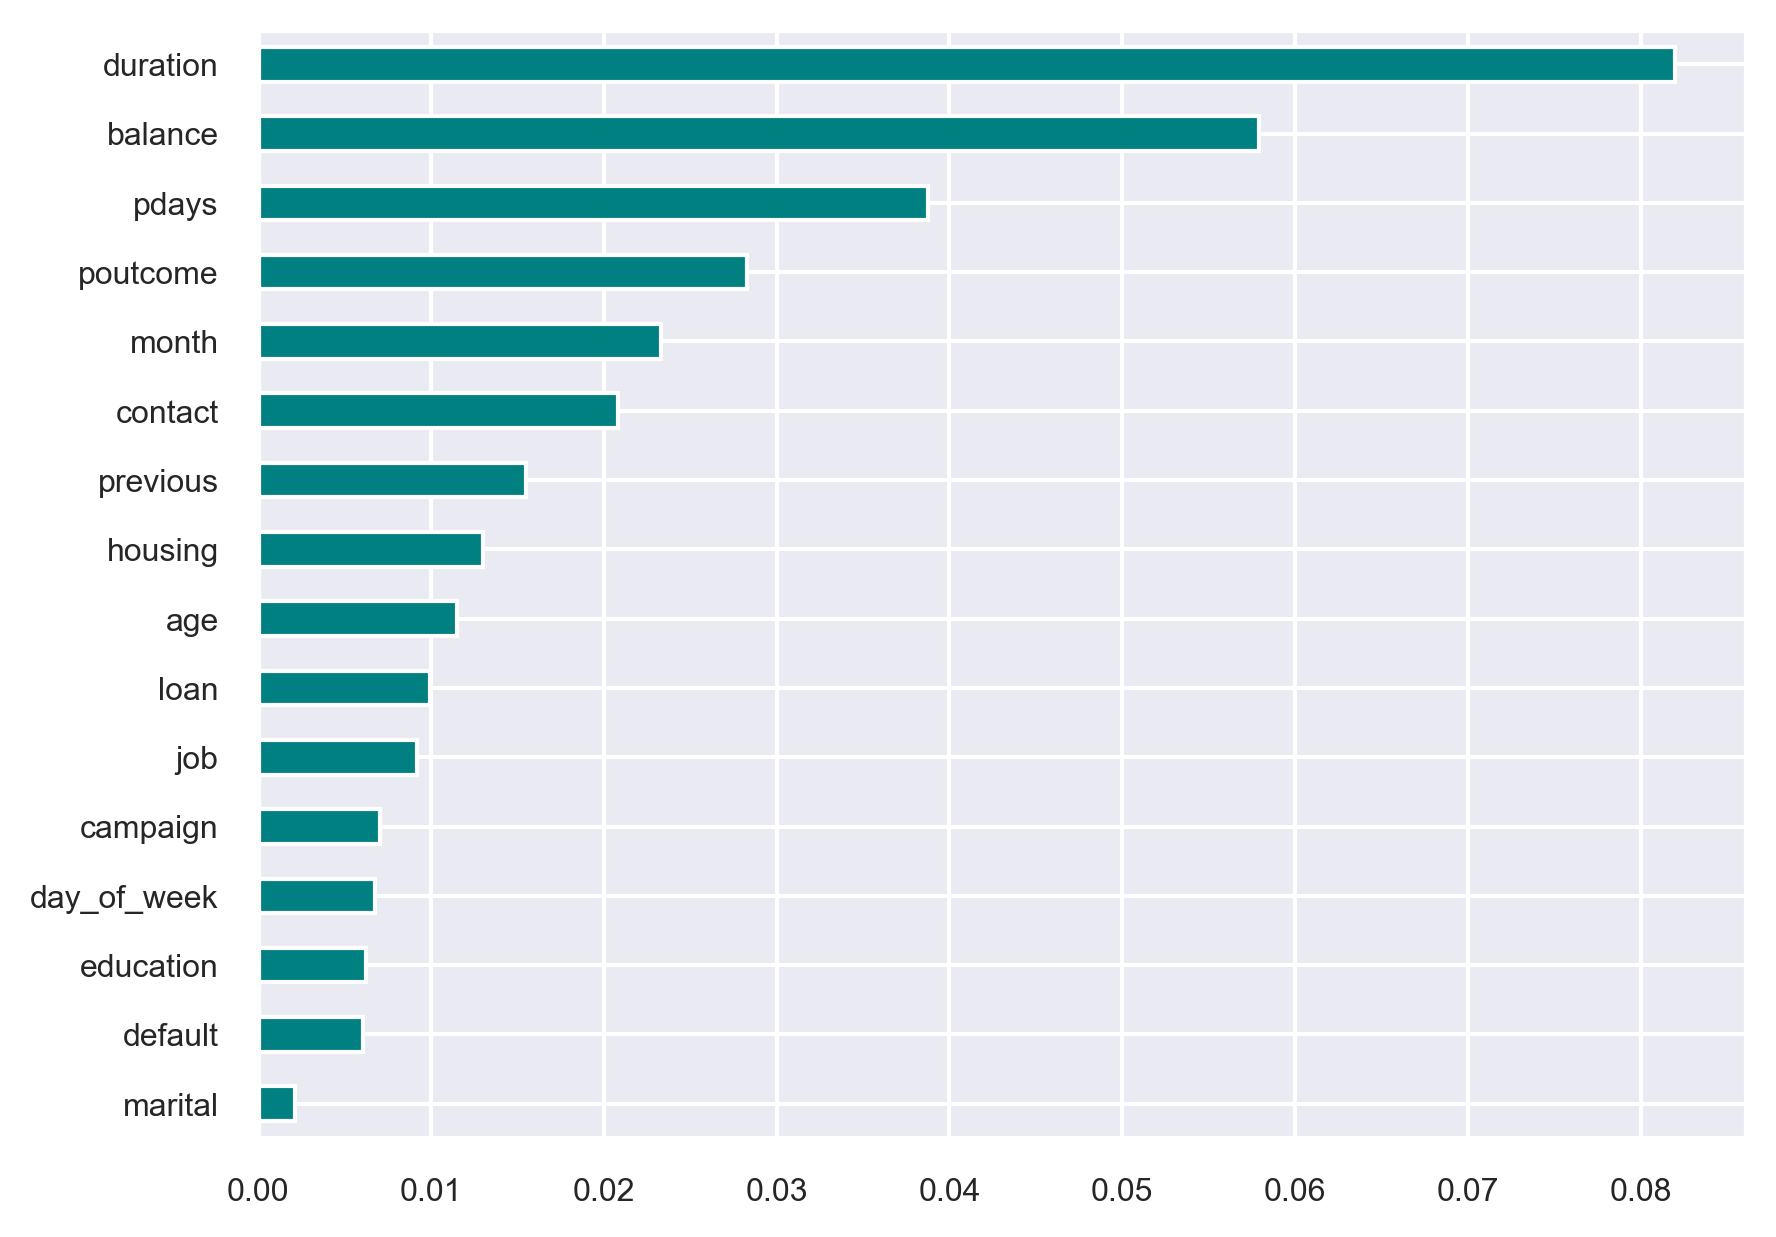

In [63]:
importances = mutual_info_classif(ndf_woe, df['y'])
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feat_importances.sort_values().plot(kind = 'barh', color = 'teal')

To reduce our number of unimportant features for modeling, we will drop the features with an information value consistently under 0.01

In [66]:
ndf_woe.drop(['education', 'day_of_week', 'marital', 'default', 'job', 'campaign'], axis = 1, inplace = True)

Finally, we will cover class imbalance by using Synthetic Minority Oversampling Technique (SMOTE)

In [67]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(ndf_woe, df['y'])
oversampled_df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

## Modeling

After testing multiple classifiers (Logistic Regression, Random Forests, Support Vector Machines), a Gradient Boosting Classifier was chosen because of better performance with our WOE encoded dataset.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(oversampled_df.drop(['y', 'duration'], axis = 1), 
                                                    oversampled_df['y'], test_size=0.30)
param_grid = { 
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 6, 9, 12], 
    'max_leaf_nodes': [3, 6, 9, 12],
} 

grid = GridSearchCV(HistGradientBoostingClassifier(),param_grid,refit=True,verbose=3, cv = 3)

# Fit the random search object to the data
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.732 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.744 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.733 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.749 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.746 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.749 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.749 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.747 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.750 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=12;, score=0.

Our model got an average f-1 score of about 90% for the dataset that does not include 'duration' in it. Great predictive power!

In [78]:
X_train, X_test, y_train, y_test = train_test_split(oversampled_df.drop(['y'], axis = 1), 
                                                    oversampled_df['y'], test_size=0.30)
param_grid = { 
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 6, 9, 12], 
    'max_leaf_nodes': [3, 6, 9, 12],
} 

grid = GridSearchCV(HistGradientBoostingClassifier(),param_grid,refit=True,verbose=3, cv = 3)

# Fit the random search object to the data
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.789 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.800 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=3;, score=0.795 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.826 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.835 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=6;, score=0.832 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.827 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.840 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=9;, score=0.837 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_leaf_nodes=12;, score=0.

The model that includes 'duration' performs better as expected, but the difference is not too big!